https://www.youtube.com/watch?v=1HqjPqNglPc

original paper: https://arxiv.org/pdf/1609.04802.pdf


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [ ]:
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation 

In [ ]:
dir = "/content/drive/MyDrive/mit computer vision project/dataset/Raw Data" 

for img in os.listdir(dir + "/high_res"):
    img_array = cv2.imread(dir + "/high_res/" + img)
    lr_img_array = cv2.resize(img_array,(64,64))
    cv2.imwrite("/content/drive/MyDrive/mit computer vision project/dataset/Raw Data/srgan_lr_images/"+ img, lr_img_array)

# SRGAN Model Setup

In [ ]:
### generator network 
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model as used in Goodfellow et al. - with 16 identical residual blocks
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)


In [ ]:
#VGG19 
#We need VGG19 for the feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer. 
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img) 
    
    disc_model.trainable = False
    validity = disc_model(gen_img) # true or false - real or fake
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])# 2 losses... adversarial loss and content (VGG) loss

#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 

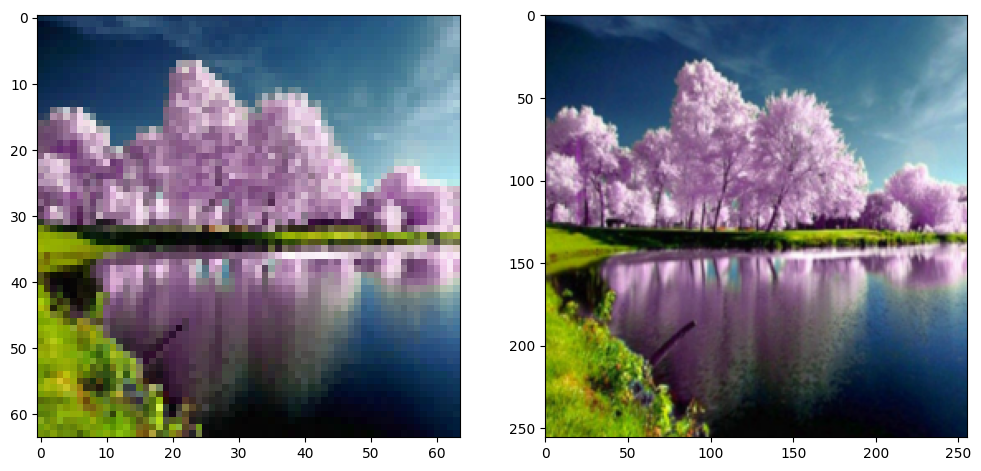

In [ ]:
lr_list = os.listdir("/content/drive/MyDrive/mit computer vision project/dataset/Raw Data/srgan_lr_images")

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("/content/drive/MyDrive/mit computer vision project/dataset/Raw Data/srgan_lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("/content/drive/MyDrive/mit computer vision project/dataset/Raw Data/high_res")
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("/content/drive/MyDrive/mit computer vision project/dataset/Raw Data/high_res/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (64, 64, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (256, 256, 3)))
plt.show()

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [ ]:
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

In [ ]:
generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

vgg = build_vgg((256,256,3)) # extract feature from hr images
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 64, 64, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

# Train Model

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 8  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 50
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 35 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/mit computer vision project/gen_e_"+ str(e+1) +".h5")

    if (e+1) % 40 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/mit computer vision project/gen_e_"+ str(e+1) +".h5")

    if (e+1) % 45 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/mit computer vision project/gen_e_"+ str(e+1) +".h5")

    if (e+1) % 50 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("/content/drive/MyDrive/mit computer vision project/gen_e_"+ str(e+1) +".h5")

  0%|          | 0/71 [00:00<?, ?it/s]WARNING:tensorflow:5 out of the last 4265 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f2ead38d360> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/71 [00:02<02:51,  2.46s/it]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/71 [00:03<02:05,  1.81s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:05<01:49,  1.61s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 4/71 [00:06<01:41,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:08<01:48,  1.65s/it]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 6/71 [00:10<01:57,  1.81s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:11<01:46,  1.66s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 8/71 [00:13<01:41,  1.61s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 9/71 [00:14<01:34,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:16<01:30,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:17<01:27,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 12/71 [00:18<01:24,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:20<01:22,  1.42s/it]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 14/71 [00:21<01:22,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


 21%|██        | 15/71 [00:23<01:32,  1.66s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:25<01:27,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 17/71 [00:26<01:22,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:28<01:26,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:30<01:20,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:31<01:16,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:32<01:13,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 22/71 [00:34<01:11,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 23/71 [00:35<01:10,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 24/71 [00:37<01:09,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:38<01:07,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 26/71 [00:40<01:05,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:41<01:03,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:42<01:01,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:44<00:59,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 30/71 [00:45<00:57,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:47<00:56,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 32/71 [00:48<01:00,  1.55s/it]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 33/71 [00:50<00:58,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:51<00:55,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:53<00:52,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 36/71 [00:54<00:50,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:55<00:48,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:57<00:47,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 39/71 [00:58<00:45,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [01:00<00:43,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [01:01<00:41,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 42/71 [01:03<00:47,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:05<00:43,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 44/71 [01:06<00:40,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 45/71 [01:07<00:37,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:09<00:35,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:10<00:33,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 48/71 [01:11<00:32,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 49/71 [01:13<00:30,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 50/71 [01:15<00:32,  1.54s/it]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 51/71 [01:17<00:33,  1.67s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 52/71 [01:18<00:29,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:19<00:27,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 54/71 [01:21<00:24,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [01:22<00:23,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:24<00:21,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:25<00:19,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 58/71 [01:26<00:18,  1.40s/it]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 59/71 [01:28<00:18,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 60/71 [01:30<00:18,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 61/71 [01:32<00:16,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 62/71 [01:33<00:13,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:34<00:11,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 64/71 [01:36<00:10,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:37<00:08,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:39<00:07,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:40<00:05,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 68/71 [01:42<00:04,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 69/71 [01:44<00:03,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:45<00:01,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


epoch: 1 g_loss: 18.66475557945144 d_loss: [0.25959471 0.97711268]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/71 [00:04<01:33,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:31,  1.37s/it]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.37s/it]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 6/71 [00:08<01:45,  1.63s/it]

1/1 [==============================] - 0s 31ms/step


 10%|▉         | 7/71 [00:10<01:41,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 8/71 [00:11<01:35,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:13<01:34,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:29,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:16<01:26,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 12/71 [00:18<01:38,  1.67s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:19<01:31,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 14/71 [00:21<01:35,  1.68s/it]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 15/71 [00:23<01:30,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:24<01:27,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 17/71 [00:25<01:22,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:27<01:18,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:28<01:15,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:30<01:12,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:31<01:10,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:32<01:08,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:34<01:14,  1.55s/it]

1/1 [==============================] - 0s 30ms/step


 34%|███▍      | 24/71 [00:36<01:11,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 25/71 [00:37<01:08,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:38<01:05,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:40<01:02,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:41<01:00,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 29/71 [00:43<00:58,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:44<00:57,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:45<00:55,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:47<00:59,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 33/71 [00:49<00:57,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 34/71 [00:50<00:56,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:52<00:53,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 36/71 [00:53<00:50,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 37/71 [00:54<00:48,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 38/71 [00:56<00:46,  1.41s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 39/71 [00:57<00:44,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:59<00:43,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [01:00<00:41,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 42/71 [01:02<00:42,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 43/71 [01:03<00:41,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 44/71 [01:04<00:38,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:06<00:37,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 46/71 [01:07<00:35,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 47/71 [01:09<00:33,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:10<00:32,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:11<00:30,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 50/71 [01:13<00:29,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 51/71 [01:14<00:28,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 52/71 [01:16<00:31,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:18<00:30,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


 76%|███████▌  | 54/71 [01:20<00:27,  1.60s/it]

1/1 [==============================] - 0s 27ms/step


 77%|███████▋  | 55/71 [01:21<00:24,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:22<00:22,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:24<00:20,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 58/71 [01:25<00:18,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:26<00:16,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 85%|████████▍ | 60/71 [01:28<00:15,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 61/71 [01:30<00:14,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 62/71 [01:31<00:13,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 63/71 [01:32<00:11,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:35<00:08,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:38<00:05,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:39<00:04,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 69/71 [01:41<00:03,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.69s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


epoch: 2 g_loss: 18.108520534676565 d_loss: [0.061662   0.99647887]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:33,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:31,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:08<01:28,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


 10%|▉         | 7/71 [00:10<01:43,  1.61s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 8/71 [00:11<01:37,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 9/71 [00:13<01:32,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 10/71 [00:14<01:29,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:15<01:25,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:17<01:23,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:18<01:21,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:19<01:19,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:17,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 16/71 [00:22<01:17,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 17/71 [00:24<01:25,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:26<01:20,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:27<01:16,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 20/71 [00:28<01:13,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:30<01:11,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:31<01:09,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 23/71 [00:33<01:07,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 24/71 [00:34<01:05,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:36<01:11,  1.55s/it]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 26/71 [00:37<01:08,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 27/71 [00:39<01:07,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 28/71 [00:40<01:03,  1.49s/it]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 29/71 [00:42<01:00,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:43<00:58,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:44<00:56,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:46<00:54,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 33/71 [00:47<00:52,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:49<00:56,  1.54s/it]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 35/71 [00:51<00:59,  1.66s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:52<00:54,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:54<00:51,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 38/71 [00:55<00:48,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:56<00:45,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 40/71 [00:58<00:43,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [00:59<00:42,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 42/71 [01:01<00:40,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 43/71 [01:03<00:44,  1.60s/it]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 44/71 [01:04<00:42,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:05<00:39,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 46/71 [01:07<00:36,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:08<00:34,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:10<00:32,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 49/71 [01:11<00:30,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:12<00:29,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:14<00:27,  1.38s/it]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 52/71 [01:16<00:29,  1.55s/it]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 53/71 [01:18<00:30,  1.68s/it]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 54/71 [01:19<00:26,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:20<00:24,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:22<00:22,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 57/71 [01:23<00:20,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 58/71 [01:24<00:18,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 59/71 [01:26<00:16,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:27<00:15,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 61/71 [01:29<00:16,  1.63s/it]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 62/71 [01:31<00:14,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:32<00:12,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [01:36<00:09,  1.61s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.53s/it]

1/1 [==============================] - 0s 27ms/step


 94%|█████████▍| 67/71 [01:38<00:05,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:42<00:03,  1.58s/it]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.55s/it]

1/1 [==============================] - 0s 37ms/step


100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


epoch: 3 g_loss: 17.668922988461777 d_loss: [4.83093533e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/71 [00:01<01:37,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:33,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 4/71 [00:05<01:32,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.37s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/71 [00:08<01:28,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:10<01:38,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█▏        | 8/71 [00:11<01:35,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 9/71 [00:13<01:37,  1.58s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 10/71 [00:14<01:32,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:16<01:28,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 12/71 [00:17<01:25,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:18<01:22,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 14/71 [00:20<01:20,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:21<01:18,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:23<01:25,  1.55s/it]

1/1 [==============================] - 0s 35ms/step


 24%|██▍       | 17/71 [00:25<01:30,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 18/71 [00:26<01:24,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:28<01:19,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:29<01:15,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 21/71 [00:30<01:12,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:32<01:10,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:33<01:07,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 24/71 [00:35<01:05,  1.40s/it]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 25/71 [00:37<01:11,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 26/71 [00:38<01:09,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 27/71 [00:39<01:06,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 28/71 [00:41<01:03,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 29/71 [00:42<01:00,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 30/71 [00:44<00:58,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:45<00:56,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:46<00:54,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:48<00:52,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:50<00:56,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 35/71 [00:51<00:54,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 36/71 [00:53<00:53,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:54<00:50,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:55<00:47,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 39/71 [00:57<00:45,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 40/71 [00:58<00:43,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 41/71 [00:59<00:42,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 42/71 [01:01<00:40,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 43/71 [01:03<00:43,  1.54s/it]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 44/71 [01:05<00:45,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:06<00:41,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 46/71 [01:07<00:37,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:09<00:35,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 48/71 [01:10<00:33,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 49/71 [01:12<00:31,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:13<00:30,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 51/71 [01:15<00:28,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 52/71 [01:16<00:27,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 53/71 [01:18<00:28,  1.61s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 54/71 [01:19<00:26,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:21<00:23,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:22<00:21,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 57/71 [01:23<00:20,  1.43s/it]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 58/71 [01:25<00:18,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 59/71 [01:26<00:16,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 60/71 [01:28<00:15,  1.40s/it]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 61/71 [01:30<00:15,  1.58s/it]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 62/71 [01:31<00:13,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:32<00:11,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 65/71 [01:35<00:08,  1.43s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:38<00:06,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 69/71 [01:42<00:03,  1.58s/it]

1/1 [==============================] - 0s 31ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


epoch: 4 g_loss: 17.335691143089615 d_loss: [3.56129348e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.36s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:33,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 4/71 [00:05<01:31,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.37s/it]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/71 [00:08<01:29,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 7/71 [00:09<01:27,  1.37s/it]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 8/71 [00:11<01:41,  1.62s/it]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 9/71 [00:13<01:37,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 10/71 [00:14<01:31,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:15<01:27,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 12/71 [00:17<01:24,  1.43s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 13/71 [00:18<01:22,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 14/71 [00:20<01:20,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:18,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:22<01:16,  1.38s/it]

1/1 [==============================] - 0s 36ms/step


 24%|██▍       | 17/71 [00:24<01:15,  1.40s/it]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 18/71 [00:26<01:25,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:27<01:20,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:29<01:16,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:30<01:12,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 22/71 [00:31<01:10,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:33<01:07,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:34<01:05,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 25/71 [00:35<01:03,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 26/71 [00:37<01:04,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 27/71 [00:39<01:06,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:40<01:03,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 29/71 [00:41<01:00,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:43<00:58,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 31/71 [00:44<00:56,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:45<00:54,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 33/71 [00:47<00:58,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:49<00:54,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 35/71 [00:50<00:53,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 36/71 [00:52<00:51,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 37/71 [00:54<00:56,  1.66s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:55<00:51,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:56<00:48,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:58<00:45,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [00:59<00:43,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 42/71 [01:01<00:41,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 43/71 [01:02<00:39,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 44/71 [01:04<00:42,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 63%|██████▎   | 45/71 [01:05<00:39,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 46/71 [01:07<00:37,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:08<00:34,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 48/71 [01:09<00:32,  1.42s/it]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 49/71 [01:11<00:30,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:12<00:29,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 51/71 [01:14<00:27,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 52/71 [01:15<00:26,  1.38s/it]

1/1 [==============================] - 0s 34ms/step


 75%|███████▍  | 53/71 [01:17<00:29,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:19<00:26,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:20<00:23,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:21<00:21,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:23<00:20,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:24<00:18,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:25<00:16,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 60/71 [01:27<00:15,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:28<00:14,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 62/71 [01:30<00:14,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:32<00:12,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:33<00:10,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [01:34<00:08,  1.44s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 66/71 [01:36<00:07,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:40<00:02,  1.39s/it]

1/1 [==============================] - 0s 29ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 71/71 [01:43<00:00,  1.45s/it]


epoch: 5 g_loss: 17.000749695468958 d_loss: [3.56028958e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.36s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:02<01:33,  1.36s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:04<01:32,  1.36s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:31,  1.36s/it]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 5/71 [00:06<01:29,  1.36s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/71 [00:08<01:28,  1.36s/it]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 7/71 [00:09<01:27,  1.36s/it]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 8/71 [00:11<01:28,  1.40s/it]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 9/71 [00:12<01:28,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:13<01:25,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 11/71 [00:15<01:23,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 12/71 [00:16<01:22,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 13/71 [00:17<01:20,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:19<01:19,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:20<01:17,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:22<01:18,  1.42s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 17/71 [00:24<01:25,  1.59s/it]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 18/71 [00:25<01:21,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 19/71 [00:27<01:17,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 20/71 [00:28<01:14,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:29<01:11,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 22/71 [00:31<01:09,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 23/71 [00:32<01:06,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 24/71 [00:33<01:05,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 25/71 [00:35<01:03,  1.38s/it]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 26/71 [00:37<01:11,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:38<01:07,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:40<01:03,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 29/71 [00:41<01:00,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:42<00:58,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 31/71 [00:44<00:56,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:45<00:54,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 33/71 [00:46<00:52,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:48<00:57,  1.55s/it]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 35/71 [00:50<00:56,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 36/71 [00:51<00:53,  1.51s/it]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 37/71 [00:53<00:49,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 38/71 [00:54<00:47,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 39/71 [00:55<00:45,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [00:57<00:43,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [00:58<00:41,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 42/71 [01:00<00:44,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 61%|██████    | 43/71 [01:02<00:46,  1.66s/it]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 44/71 [01:03<00:42,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:05<00:39,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:06<00:36,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:07<00:34,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:09<00:32,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 49/71 [01:10<00:31,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 50/71 [01:12<00:29,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 51/71 [01:13<00:28,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 52/71 [01:15<00:27,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:16<00:25,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:17<00:23,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 55/71 [01:19<00:22,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 56/71 [01:20<00:20,  1.39s/it]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 57/71 [01:22<00:19,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 58/71 [01:23<00:17,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:24<00:16,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 60/71 [01:26<00:17,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:28<00:15,  1.54s/it]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 62/71 [01:29<00:13,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 63/71 [01:31<00:11,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:33<00:11,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:34<00:09,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 66/71 [01:35<00:07,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.47s/it]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 69/71 [01:40<00:03,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:43<00:00,  1.45s/it]


epoch: 6 g_loss: 16.8514340897681 d_loss: [3.55921039e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.37s/it]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/71 [00:04<01:32,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:31,  1.37s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 5/71 [00:07<01:42,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


  8%|▊         | 6/71 [00:08<01:39,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:37,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 8/71 [00:11<01:33,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 9/71 [00:13<01:29,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 10/71 [00:14<01:26,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:15<01:24,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 12/71 [00:17<01:22,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:18<01:20,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:19<01:19,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 15/71 [00:21<01:27,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:23<01:22,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 17/71 [00:24<01:18,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:26<01:15,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:27<01:13,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:28<01:11,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:30<01:09,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 22/71 [00:31<01:07,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 23/71 [00:33<01:14,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 34%|███▍      | 24/71 [00:34<01:12,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:36<01:08,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 26/71 [00:37<01:05,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:39<01:02,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:40<01:00,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 29/71 [00:41<00:58,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 30/71 [00:43<00:56,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 31/71 [00:44<00:55,  1.38s/it]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 32/71 [00:46<01:00,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 33/71 [00:47<00:57,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:49<00:54,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:50<00:51,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:51<00:49,  1.41s/it]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 37/71 [00:53<00:47,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:54<00:46,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:56<00:44,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:57<00:43,  1.39s/it]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 41/71 [00:59<00:48,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 42/71 [01:00<00:44,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:02<00:41,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:03<00:39,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 45/71 [01:05<00:37,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 46/71 [01:06<00:35,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 47/71 [01:07<00:33,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:09<00:32,  1.40s/it]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 49/71 [01:11<00:34,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 50/71 [01:12<00:32,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:14<00:30,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 52/71 [01:15<00:27,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:16<00:25,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 54/71 [01:18<00:24,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:19<00:22,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:20<00:20,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:22<00:21,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 58/71 [01:24<00:19,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 59/71 [01:25<00:17,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:27<00:15,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 61/71 [01:28<00:14,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:29<00:12,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 63/71 [01:31<00:11,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:32<00:09,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:33<00:08,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 66/71 [01:35<00:07,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 69/71 [01:39<00:02,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 71/71 [01:42<00:00,  1.44s/it]


epoch: 7 g_loss: 16.762338235344686 d_loss: [3.55798671e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.36s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:04<01:32,  1.36s/it]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 4/71 [00:05<01:38,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


  7%|▋         | 5/71 [00:07<01:36,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/71 [00:08<01:33,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:09<01:30,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 8/71 [00:11<01:28,  1.40s/it]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 9/71 [00:12<01:26,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:24,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:15<01:22,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:16<01:21,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 18%|█▊        | 13/71 [00:18<01:30,  1.56s/it]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 14/71 [00:20<01:28,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:23,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:23<01:19,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 17/71 [00:24<01:16,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:25<01:14,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 19/71 [00:27<01:12,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 20/71 [00:28<01:10,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:30<01:18,  1.57s/it]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 22/71 [00:32<01:18,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:33<01:13,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:34<01:09,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:36<01:06,  1.45s/it]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 26/71 [00:37<01:04,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:39<01:02,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:40<01:00,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:42<01:05,  1.57s/it]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 30/71 [00:43<01:04,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:45<01:01,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:46<00:58,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:48<00:55,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:49<00:53,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:50<00:51,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:52<00:50,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:54<00:53,  1.58s/it]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 38/71 [00:55<00:52,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 39/71 [00:57<00:49,  1.54s/it]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 40/71 [00:58<00:46,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 41/71 [01:00<00:44,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 42/71 [01:01<00:42,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:03<00:40,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:04<00:38,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 45/71 [01:05<00:37,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 46/71 [01:07<00:37,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████▌   | 47/71 [01:09<00:37,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:10<00:35,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 49/71 [01:12<00:33,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 50/71 [01:13<00:30,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 51/71 [01:15<00:29,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 52/71 [01:16<00:27,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:17<00:25,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:19<00:26,  1.58s/it]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 55/71 [01:21<00:25,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:22<00:23,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:24<00:21,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 58/71 [01:25<00:19,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:27<00:17,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:28<00:16,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 61/71 [01:29<00:14,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 62/71 [01:31<00:14,  1.59s/it]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 63/71 [01:33<00:12,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:36<00:09,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 67/71 [01:39<00:05,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 69/71 [01:42<00:02,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 70/71 [01:44<00:01,  1.59s/it]

1/1 [==============================] - 0s 35ms/step


100%|██████████| 71/71 [01:45<00:00,  1.49s/it]


epoch: 8 g_loss: 16.678631272114497 d_loss: [3.55665153e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:39,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/71 [00:02<01:37,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:36,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 4/71 [00:05<01:36,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 5/71 [00:07<01:34,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:08<01:32,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:09<01:31,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 8/71 [00:12<01:43,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:13<01:38,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 10/71 [00:15<01:33,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:16<01:31,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 12/71 [00:17<01:28,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:19<01:25,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 14/71 [00:20<01:23,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:22<01:20,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 16/71 [00:24<01:27,  1.59s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 17/71 [00:25<01:24,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:26<01:19,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:28<01:15,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:29<01:13,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 21/71 [00:31<01:10,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:32<01:08,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 23/71 [00:33<01:07,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:35<01:14,  1.59s/it]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 25/71 [00:37<01:13,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:38<01:09,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:40<01:06,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:41<01:03,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:43<01:01,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:44<00:59,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:46<00:57,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:47<00:55,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 46%|████▋     | 33/71 [00:49<00:58,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:50<00:57,  1.56s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 35/71 [00:52<00:54,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 36/71 [00:53<00:51,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:55<00:49,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:56<00:47,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 39/71 [00:57<00:46,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 40/71 [00:59<00:45,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 41/71 [01:00<00:44,  1.49s/it]

1/1 [==============================] - 0s 35ms/step


 59%|█████▉    | 42/71 [01:02<00:45,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:04<00:42,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 44/71 [01:05<00:40,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:07<00:38,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 46/71 [01:08<00:36,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:09<00:34,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:11<00:33,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 49/71 [01:13<00:34,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 50/71 [01:14<00:33,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:16<00:30,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 52/71 [01:17<00:28,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:19<00:26,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 54/71 [01:20<00:24,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:22<00:23,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:23<00:21,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:24<00:20,  1.44s/it]

1/1 [==============================] - 0s 32ms/step


 82%|████████▏ | 58/71 [01:26<00:21,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:28<00:19,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 60/71 [01:29<00:16,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:31<00:15,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:32<00:13,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:34<00:11,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:35<00:10,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 65/71 [01:36<00:08,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 66/71 [01:38<00:07,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 67/71 [01:40<00:06,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 68/71 [01:41<00:04,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:42<00:02,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 70/71 [01:44<00:01,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:45<00:00,  1.49s/it]


epoch: 9 g_loss: 16.664887199939137 d_loss: [3.55517414e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:39,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:03<01:58,  1.72s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:05<02:05,  1.84s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 4/71 [00:07<02:01,  1.81s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:08<01:50,  1.67s/it]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/71 [00:09<01:43,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:11<01:39,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 8/71 [00:12<01:35,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 9/71 [00:14<01:32,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:29,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 11/71 [00:17<01:39,  1.66s/it]

1/1 [==============================] - 0s 34ms/step


 17%|█▋        | 12/71 [00:19<01:37,  1.65s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 13/71 [00:20<01:31,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 14/71 [00:22<01:27,  1.53s/it]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 15/71 [00:23<01:24,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:25<01:21,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 17/71 [00:26<01:19,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:28<01:17,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:29<01:23,  1.60s/it]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 20/71 [00:31<01:21,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 21/71 [00:32<01:16,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 22/71 [00:34<01:14,  1.51s/it]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 23/71 [00:35<01:11,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 24/71 [00:37<01:08,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 25/71 [00:38<01:06,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:39<01:03,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:41<01:08,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 28/71 [00:43<01:12,  1.68s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:45<01:06,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:46<01:02,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:47<00:59,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:49<00:57,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 46%|████▋     | 33/71 [00:51<01:00,  1.60s/it]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 34/71 [00:52<00:56,  1.54s/it]

1/1 [==============================] - 0s 28ms/step


 49%|████▉     | 35/71 [00:54<00:53,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 36/71 [00:56<00:59,  1.69s/it]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 37/71 [00:57<00:54,  1.60s/it]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 38/71 [00:59<00:50,  1.54s/it]

1/1 [==============================] - 0s 28ms/step


 55%|█████▍    | 39/71 [01:00<00:47,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 40/71 [01:01<00:45,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 58%|█████▊    | 41/71 [01:03<00:43,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 42/71 [01:04<00:41,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 43/71 [01:06<00:39,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 44/71 [01:08<00:44,  1.65s/it]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 45/71 [01:09<00:40,  1.57s/it]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 46/71 [01:10<00:37,  1.52s/it]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 47/71 [01:12<00:35,  1.48s/it]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 48/71 [01:13<00:33,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 49/71 [01:15<00:31,  1.45s/it]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 50/71 [01:16<00:30,  1.43s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 51/71 [01:17<00:28,  1.42s/it]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 52/71 [01:19<00:29,  1.57s/it]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 53/71 [01:22<00:31,  1.75s/it]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 54/71 [01:23<00:28,  1.68s/it]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 55/71 [01:24<00:25,  1.59s/it]

1/1 [==============================] - 0s 32ms/step


 79%|███████▉  | 56/71 [01:26<00:22,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 80%|████████  | 57/71 [01:27<00:21,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 82%|████████▏ | 58/71 [01:29<00:19,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 59/71 [01:30<00:17,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 85%|████████▍ | 60/71 [01:32<00:17,  1.61s/it]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 61/71 [01:34<00:15,  1.57s/it]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 63/71 [01:36<00:11,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 65/71 [01:39<00:08,  1.44s/it]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.43s/it]

1/1 [==============================] - 0s 28ms/step


 94%|█████████▍| 67/71 [01:42<00:05,  1.42s/it]

1/1 [==============================] - 0s 32ms/step


 96%|█████████▌| 68/71 [01:43<00:04,  1.41s/it]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 69/71 [01:45<00:02,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.51s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


epoch: 10 g_loss: 16.467460417411697 d_loss: [3.55356994e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/71 [00:01<01:36,  1.38s/it]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 2/71 [00:03<01:56,  1.69s/it]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 3/71 [00:04<01:45,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 4/71 [00:06<01:39,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 5/71 [00:07<01:35,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 6/71 [00:08<01:36,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 10%|▉         | 7/71 [00:10<01:35,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 8/71 [00:11<01:32,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 9/71 [00:13<01:29,  1.44s/it]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 10/71 [00:14<01:26,  1.42s/it]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 11/71 [00:16<01:24,  1.42s/it]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 12/71 [00:17<01:22,  1.40s/it]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 13/71 [00:18<01:21,  1.40s/it]

1/1 [==============================] - 0s 29ms/step


 20%|█▉        | 14/71 [00:20<01:19,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 15/71 [00:21<01:22,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██▎       | 16/71 [00:23<01:21,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 17/71 [00:24<01:18,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 18/71 [00:26<01:16,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 27%|██▋       | 19/71 [00:27<01:14,  1.43s/it]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 20/71 [00:28<01:12,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 21/71 [00:30<01:10,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 22/71 [00:31<01:09,  1.41s/it]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 23/71 [00:33<01:14,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 24/71 [00:35<01:20,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 25/71 [00:37<01:14,  1.61s/it]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 26/71 [00:38<01:09,  1.55s/it]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 27/71 [00:39<01:06,  1.50s/it]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 28/71 [00:41<01:03,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 29/71 [00:42<01:00,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 42%|████▏     | 30/71 [00:44<00:58,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 31/71 [00:46<01:03,  1.58s/it]

1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 32/71 [00:47<01:02,  1.60s/it]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 33/71 [00:49<00:58,  1.54s/it]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 34/71 [00:50<00:55,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 35/71 [00:51<00:52,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 36/71 [00:53<00:50,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 37/71 [00:54<00:48,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


 54%|█████▎    | 38/71 [00:56<00:47,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


 55%|█████▍    | 39/71 [00:57<00:45,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 40/71 [00:59<00:45,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 41/71 [01:00<00:45,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 42/71 [01:02<00:43,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 43/71 [01:03<00:40,  1.46s/it]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 44/71 [01:04<00:38,  1.44s/it]

1/1 [==============================] - 0s 30ms/step


 63%|██████▎   | 45/71 [01:06<00:36,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 46/71 [01:07<00:35,  1.41s/it]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 47/71 [01:09<00:33,  1.41s/it]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 48/71 [01:10<00:32,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 69%|██████▉   | 49/71 [01:12<00:35,  1.63s/it]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 50/71 [01:14<00:32,  1.56s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 51/71 [01:15<00:30,  1.51s/it]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 52/71 [01:16<00:28,  1.47s/it]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 53/71 [01:18<00:26,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 54/71 [01:19<00:24,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 55/71 [01:21<00:22,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 56/71 [01:22<00:21,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 57/71 [01:24<00:22,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 58/71 [01:26<00:20,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 59/71 [01:27<00:18,  1.54s/it]

1/1 [==============================] - 0s 28ms/step


 85%|████████▍ | 60/71 [01:28<00:16,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 61/71 [01:30<00:14,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 87%|████████▋ | 62/71 [01:31<00:12,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 63/71 [01:33<00:11,  1.43s/it]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 64/71 [01:34<00:09,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 65/71 [01:35<00:08,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 67/71 [01:39<00:06,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 97%|█████████▋| 69/71 [01:41<00:02,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 71/71 [01:44<00:00,  1.48s/it]


epoch: 11 g_loss: 16.523056527258646 d_loss: [3.55177513e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.36s/it]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 37ms/step


  4%|▍         | 3/71 [00:04<01:53,  1.67s/it]

1/1 [==============================] - 0s 40ms/step


  6%|▌         | 4/71 [00:06<01:47,  1.60s/it]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 5/71 [00:07<01:41,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 6/71 [00:09<01:36,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 7/71 [00:10<01:33,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 11%|█▏        | 8/71 [00:11<01:30,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:13<01:27,  1.42s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 10/71 [00:14<01:25,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 11/71 [00:16<01:24,  1.40s/it]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 12/71 [00:17<01:29,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 13/71 [00:19<01:26,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 14/71 [00:20<01:23,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:21<01:20,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:23<01:17,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 17/71 [00:24<01:15,  1.40s/it]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 18/71 [00:26<01:14,  1.40s/it]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 19/71 [00:27<01:12,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 20/71 [00:29<01:19,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 21/71 [00:31<01:23,  1.68s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:32<01:17,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 23/71 [00:34<01:13,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 24/71 [00:35<01:09,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:36<01:06,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 26/71 [00:38<01:04,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:39<01:02,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 28/71 [00:41<01:06,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 29/71 [00:42<01:03,  1.52s/it]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 30/71 [00:44<01:00,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:45<00:58,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:47<00:55,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 33/71 [00:48<00:53,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 34/71 [00:49<00:51,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:51<00:50,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 36/71 [00:52<00:48,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 37/71 [00:54<00:47,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 38/71 [00:55<00:49,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:57<00:46,  1.47s/it]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 40/71 [00:58<00:44,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 41/71 [00:59<00:42,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 42/71 [01:01<00:40,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 43/71 [01:02<00:39,  1.41s/it]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 44/71 [01:04<00:37,  1.40s/it]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 45/71 [01:05<00:36,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 46/71 [01:07<00:39,  1.58s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 47/71 [01:09<00:40,  1.70s/it]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 48/71 [01:10<00:36,  1.60s/it]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 49/71 [01:12<00:34,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:13<00:31,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 51/71 [01:15<00:29,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 52/71 [01:16<00:27,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 53/71 [01:17<00:25,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 76%|███████▌  | 54/71 [01:19<00:25,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 55/71 [01:21<00:23,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:22<00:21,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 57/71 [01:23<00:19,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 58/71 [01:25<00:18,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 59/71 [01:26<00:16,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 60/71 [01:27<00:15,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:29<00:13,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 62/71 [01:30<00:12,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


 89%|████████▊ | 63/71 [01:32<00:11,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 64/71 [01:34<00:11,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:35<00:09,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 66/71 [01:36<00:07,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:38<00:05,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 68/71 [01:39<00:04,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 69/71 [01:40<00:02,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:42<00:01,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 71/71 [01:44<00:00,  1.47s/it]


epoch: 12 g_loss: 18.811040314150528 d_loss: [3.54985292e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 1/71 [00:01<01:48,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:03<01:45,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:39,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:35,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:07<01:33,  1.41s/it]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/71 [00:08<01:30,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:09<01:28,  1.39s/it]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 8/71 [00:11<01:27,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 9/71 [00:13<01:36,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 14%|█▍        | 10/71 [00:15<01:46,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:16<01:37,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:18<01:31,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:19<01:26,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 14/71 [00:20<01:23,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 15/71 [00:22<01:20,  1.43s/it]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 16/71 [00:23<01:18,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:25<01:15,  1.41s/it]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 18/71 [00:26<01:18,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 19/71 [00:28<01:15,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 20/71 [00:29<01:13,  1.43s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 21/71 [00:30<01:11,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 22/71 [00:32<01:09,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:33<01:07,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 24/71 [00:35<01:05,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 25/71 [00:36<01:03,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:38<01:09,  1.54s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 27/71 [00:39<01:07,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 28/71 [00:41<01:03,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 29/71 [00:42<01:00,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:43<00:58,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:45<00:56,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:46<00:54,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:48<00:53,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:49<00:51,  1.39s/it]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 35/71 [00:51<00:56,  1.57s/it]

1/1 [==============================] - 0s 32ms/step


 51%|█████     | 36/71 [00:52<00:53,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 37/71 [00:54<00:50,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:55<00:48,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 39/71 [00:57<00:45,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:58<00:44,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 41/71 [00:59<00:42,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 42/71 [01:01<00:40,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:03<00:43,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 44/71 [01:04<00:41,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:06<00:39,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:07<00:36,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 47/71 [01:08<00:34,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 48/71 [01:10<00:32,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:11<00:31,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 50/71 [01:12<00:29,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 51/71 [01:14<00:27,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 52/71 [01:15<00:28,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 53/71 [01:17<00:27,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:18<00:25,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 55/71 [01:20<00:23,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:21<00:21,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:23<00:19,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 58/71 [01:24<00:18,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 83%|████████▎ | 59/71 [01:25<00:16,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 60/71 [01:27<00:17,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 61/71 [01:29<00:15,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:30<00:13,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:32<00:11,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:33<00:10,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 65/71 [01:34<00:08,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 93%|█████████▎| 66/71 [01:36<00:07,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:40<00:03,  1.55s/it]

1/1 [==============================] - 0s 30ms/step


 99%|█████████▊| 70/71 [01:42<00:01,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 71/71 [01:43<00:00,  1.46s/it]


epoch: 13 g_loss: 3082.3468306366826 d_loss: [3.54773084e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:36,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:02<01:35,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:04<01:34,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:05<01:32,  1.38s/it]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 5/71 [00:06<01:31,  1.38s/it]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 6/71 [00:08<01:30,  1.39s/it]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 7/71 [00:09<01:34,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█▏        | 8/71 [00:11<01:35,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:12<01:31,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 10/71 [00:14<01:28,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 11/71 [00:15<01:26,  1.43s/it]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 12/71 [00:17<01:23,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:18<01:21,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:19<01:19,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 15/71 [00:21<01:18,  1.40s/it]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 16/71 [00:22<01:21,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 17/71 [00:24<01:19,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 25%|██▌       | 18/71 [00:25<01:16,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:27<01:14,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 20/71 [00:28<01:12,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 21/71 [00:29<01:10,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:31<01:08,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:32<01:06,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:34<01:12,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 25/71 [00:36<01:10,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:37<01:06,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:38<01:03,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 28/71 [00:40<01:01,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 29/71 [00:41<00:59,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 30/71 [00:42<00:57,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:44<00:55,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 32/71 [00:45<00:54,  1.39s/it]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 33/71 [00:47<00:59,  1.56s/it]

1/1 [==============================] - 0s 35ms/step


 48%|████▊     | 34/71 [00:49<00:58,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 35/71 [00:50<00:55,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:52<00:51,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 37/71 [00:53<00:49,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:54<00:47,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:56<00:45,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:57<00:43,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 41/71 [00:59<00:46,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 42/71 [01:01<00:48,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:02<00:44,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 44/71 [01:04<00:41,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 45/71 [01:05<00:38,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 46/71 [01:06<00:36,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:08<00:34,  1.43s/it]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 48/71 [01:09<00:32,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 49/71 [01:11<00:35,  1.60s/it]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 50/71 [01:13<00:36,  1.74s/it]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 51/71 [01:15<00:32,  1.63s/it]

1/1 [==============================] - 0s 30ms/step


 73%|███████▎  | 52/71 [01:16<00:29,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [01:18<00:27,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 54/71 [01:19<00:24,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:20<00:22,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:22<00:21,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:23<00:21,  1.56s/it]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 58/71 [01:25<00:21,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:27<00:19,  1.59s/it]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 60/71 [01:28<00:16,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 61/71 [01:30<00:14,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:31<00:13,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:32<00:11,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:34<00:09,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:35<00:08,  1.41s/it]

1/1 [==============================] - 0s 30ms/step


 93%|█████████▎| 66/71 [01:37<00:08,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:39<00:06,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.51s/it]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 69/71 [01:41<00:02,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:44<00:00,  1.48s/it]


epoch: 14 g_loss: 123.81583017698476 d_loss: [3.54540216e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:02<01:35,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:49,  1.61s/it]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 4/71 [00:06<01:43,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 5/71 [00:07<01:38,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:08<01:34,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 7/71 [00:10<01:42,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 8/71 [00:12<01:36,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:13<01:32,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 10/71 [00:14<01:28,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:16<01:26,  1.43s/it]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 12/71 [00:18<01:37,  1.66s/it]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 13/71 [00:19<01:31,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:21<01:26,  1.51s/it]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 15/71 [00:22<01:22,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 16/71 [00:24<01:19,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 17/71 [00:25<01:17,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:26<01:15,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:28<01:15,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 20/71 [00:29<01:16,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 30%|██▉       | 21/71 [00:31<01:17,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 22/71 [00:32<01:13,  1.50s/it]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 23/71 [00:34<01:10,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 24/71 [00:36<01:15,  1.60s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 25/71 [00:37<01:10,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 26/71 [00:39<01:06,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:40<01:03,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:42<01:08,  1.59s/it]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 29/71 [00:43<01:06,  1.58s/it]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 30/71 [00:45<01:04,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:46<01:01,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 32/71 [00:48<00:58,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:49<00:55,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 34/71 [00:51<00:53,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:52<00:51,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:53<00:50,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 37/71 [00:55<00:54,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:57<00:51,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 39/71 [00:58<00:47,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [01:00<00:45,  1.46s/it]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 41/71 [01:01<00:43,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 42/71 [01:02<00:41,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 43/71 [01:04<00:39,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 44/71 [01:05<00:37,  1.40s/it]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 45/71 [01:07<00:36,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 46/71 [01:09<00:39,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:10<00:36,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 48/71 [01:11<00:34,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:13<00:31,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 50/71 [01:14<00:29,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:15<00:28,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 52/71 [01:17<00:26,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:18<00:25,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 54/71 [01:20<00:24,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 55/71 [01:22<00:24,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:23<00:22,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:24<00:20,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:26<00:18,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:27<00:17,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 60/71 [01:29<00:15,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:30<00:14,  1.40s/it]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 62/71 [01:31<00:12,  1.40s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 63/71 [01:33<00:11,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:36<00:08,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 67/71 [01:38<00:05,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:41<00:02,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


epoch: 15 g_loss: 101.18960958131602 d_loss: [3.54286213e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 1/71 [00:01<02:02,  1.74s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:03<01:45,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:04<01:39,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 4/71 [00:05<01:35,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:07<01:32,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:08<01:30,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:09<01:28,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:11<01:37,  1.55s/it]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 9/71 [00:13<01:45,  1.70s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 10/71 [00:15<01:37,  1.60s/it]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 11/71 [00:16<01:32,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:18<01:27,  1.49s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 13/71 [00:19<01:24,  1.46s/it]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 14/71 [00:20<01:21,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:22<01:19,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:23<01:17,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 17/71 [00:25<01:25,  1.57s/it]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 18/71 [00:26<01:21,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:28<01:17,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 20/71 [00:29<01:14,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 21/71 [00:31<01:15,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:32<01:12,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:34<01:09,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 24/71 [00:35<01:07,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:37<01:13,  1.59s/it]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 26/71 [00:39<01:10,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:40<01:06,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:41<01:03,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:43<01:00,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:44<00:58,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:45<00:56,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:47<00:55,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:48<00:53,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 34/71 [00:50<01:00,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:52<00:56,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:53<00:52,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 37/71 [00:55<00:49,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:56<00:47,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 39/71 [00:57<00:45,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:59<00:43,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 41/71 [01:00<00:41,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 42/71 [01:02<00:46,  1.59s/it]

1/1 [==============================] - 0s 33ms/step


 61%|██████    | 43/71 [01:04<00:43,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:05<00:40,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 45/71 [01:06<00:39,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 46/71 [01:08<00:37,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 47/71 [01:09<00:35,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:11<00:33,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 49/71 [01:12<00:31,  1.42s/it]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 50/71 [01:14<00:32,  1.56s/it]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 51/71 [01:15<00:30,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:17<00:28,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:18<00:26,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 54/71 [01:20<00:25,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 55/71 [01:21<00:23,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:23<00:21,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:24<00:20,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 58/71 [01:26<00:21,  1.63s/it]

1/1 [==============================] - 0s 35ms/step


 83%|████████▎ | 59/71 [01:28<00:19,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 60/71 [01:29<00:17,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:31<00:15,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:32<00:13,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 63/71 [01:34<00:11,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 64/71 [01:35<00:10,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:37<00:08,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:39<00:08,  1.63s/it]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 67/71 [01:40<00:06,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:42<00:04,  1.61s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:43<00:03,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:45<00:01,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:46<00:00,  1.50s/it]


epoch: 16 g_loss: 98.2399028724348 d_loss: [3.54011065e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/71 [00:01<01:39,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:38,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/71 [00:04<01:36,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


  6%|▌         | 4/71 [00:06<01:58,  1.76s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:08<01:49,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/71 [00:09<01:42,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:38,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 11%|█▏        | 8/71 [00:12<01:34,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 9/71 [00:13<01:33,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 10/71 [00:15<01:30,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 11/71 [00:17<01:38,  1.65s/it]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 12/71 [00:19<01:45,  1.79s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 13/71 [00:20<01:38,  1.70s/it]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 14/71 [00:22<01:32,  1.62s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 15/71 [00:23<01:27,  1.56s/it]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 16/71 [00:25<01:23,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 17/71 [00:26<01:21,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:28<01:18,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:30<01:24,  1.62s/it]

1/1 [==============================] - 0s 30ms/step


 28%|██▊       | 20/71 [00:31<01:22,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 21/71 [00:33<01:17,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 22/71 [00:34<01:14,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 23/71 [00:36<01:12,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:37<01:11,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 25/71 [00:38<01:08,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:40<01:06,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:41<01:04,  1.47s/it]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 28/71 [00:43<01:05,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 29/71 [00:45<01:03,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 30/71 [00:46<01:01,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:47<00:58,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:49<00:57,  1.46s/it]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 33/71 [00:50<00:55,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:52<00:54,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:53<00:53,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 36/71 [00:55<00:52,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 37/71 [00:57<00:54,  1.59s/it]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 38/71 [00:58<00:50,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 39/71 [00:59<00:48,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [01:01<00:46,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [01:02<00:44,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 42/71 [01:04<00:42,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:05<00:40,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:07<00:43,  1.63s/it]

1/1 [==============================] - 0s 31ms/step


 63%|██████▎   | 45/71 [01:09<00:42,  1.62s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:10<00:39,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 47/71 [01:12<00:36,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 49/71 [01:15<00:32,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:16<00:31,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:18<00:29,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:19<00:30,  1.61s/it]

1/1 [==============================] - 0s 30ms/step


 75%|███████▍  | 53/71 [01:21<00:28,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:23<00:26,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:24<00:24,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:25<00:22,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:27<00:20,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:28<00:18,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 83%|████████▎ | 59/71 [01:30<00:17,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:31<00:15,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 86%|████████▌ | 61/71 [01:33<00:16,  1.65s/it]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 62/71 [01:35<00:14,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:36<00:12,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 64/71 [01:37<00:10,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:39<00:09,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 66/71 [01:40<00:07,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:42<00:05,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 68/71 [01:43<00:04,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 97%|█████████▋| 69/71 [01:45<00:02,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


epoch: 17 g_loss: 87.89288792140047 d_loss: [3.53701637e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/71 [00:01<01:36,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:02<01:35,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:33,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 4/71 [00:05<01:32,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:06<01:31,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/71 [00:08<01:29,  1.38s/it]

1/1 [==============================] - 0s 34ms/step


 10%|▉         | 7/71 [00:09<01:30,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█▏        | 8/71 [00:11<01:33,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 9/71 [00:12<01:31,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 10/71 [00:14<01:29,  1.46s/it]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 11/71 [00:15<01:28,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 12/71 [00:17<01:26,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 13/71 [00:18<01:24,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:20<01:22,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:22<01:29,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██▎       | 16/71 [00:23<01:27,  1.59s/it]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 17/71 [00:25<01:23,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:26<01:22,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:28<01:17,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 20/71 [00:29<01:14,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 21/71 [00:30<01:12,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 22/71 [00:32<01:09,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 23/71 [00:33<01:09,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 24/71 [00:35<01:18,  1.67s/it]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 25/71 [00:37<01:13,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:38<01:09,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:40<01:06,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 28/71 [00:41<01:03,  1.49s/it]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 29/71 [00:43<01:09,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 30/71 [00:45<01:05,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:47<01:09,  1.74s/it]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 32/71 [00:48<01:05,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 33/71 [00:50<01:02,  1.63s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 34/71 [00:51<00:58,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:53<00:55,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:54<00:52,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 37/71 [00:55<00:50,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:57<00:48,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 39/71 [00:58<00:46,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 40/71 [01:01<00:52,  1.69s/it]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 41/71 [01:02<00:48,  1.61s/it]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 42/71 [01:03<00:45,  1.56s/it]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 43/71 [01:05<00:44,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:07<00:41,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 45/71 [01:08<00:39,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 46/71 [01:09<00:37,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:11<00:35,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 48/71 [01:13<00:38,  1.68s/it]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 49/71 [01:14<00:35,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 50/71 [01:16<00:32,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 51/71 [01:17<00:30,  1.54s/it]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 52/71 [01:19<00:28,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:20<00:26,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:22<00:24,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [01:23<00:23,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 79%|███████▉  | 56/71 [01:25<00:24,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:27<00:24,  1.74s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 58/71 [01:29<00:21,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:30<00:19,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:32<00:17,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:33<00:15,  1.56s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 63/71 [01:37<00:13,  1.65s/it]

1/1 [==============================] - 0s 36ms/step


 90%|█████████ | 64/71 [01:38<00:11,  1.63s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 65/71 [01:40<00:09,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:43<00:06,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:46<00:02,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 18 g_loss: 65.45798873901367 d_loss: [3.53370758e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 1/71 [00:01<01:52,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:03<01:44,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 3/71 [00:04<01:40,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:05<01:37,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:07<01:36,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:08<01:35,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:10<01:33,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 8/71 [00:11<01:31,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 9/71 [00:14<01:45,  1.71s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 10/71 [00:15<01:38,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:16<01:33,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 12/71 [00:18<01:32,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:19<01:28,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 14/71 [00:21<01:26,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 15/71 [00:22<01:24,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 16/71 [00:24<01:30,  1.64s/it]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 17/71 [00:26<01:27,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 18/71 [00:27<01:22,  1.56s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:29<01:20,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 20/71 [00:30<01:16,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:32<01:15,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:33<01:12,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:35<01:10,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 24/71 [00:37<01:16,  1.63s/it]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 25/71 [00:38<01:14,  1.62s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 26/71 [00:40<01:16,  1.71s/it]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 27/71 [00:42<01:11,  1.63s/it]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 28/71 [00:43<01:06,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:44<01:03,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 30/71 [00:46<01:00,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:47<00:57,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:49<01:01,  1.57s/it]

1/1 [==============================] - 0s 30ms/step


 46%|████▋     | 33/71 [00:50<00:58,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 34/71 [00:52<00:55,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:53<00:53,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:55<00:51,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 37/71 [00:56<00:50,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:58<00:48,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:59<00:46,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [01:01<00:44,  1.44s/it]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 41/71 [01:02<00:46,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 42/71 [01:04<00:45,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:05<00:43,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:07<00:40,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:08<00:38,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:10<00:36,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:11<00:36,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 49/71 [01:15<00:36,  1.67s/it]

1/1 [==============================] - 0s 33ms/step


 70%|███████   | 50/71 [01:16<00:34,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:18<00:31,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 52/71 [01:19<00:29,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 53/71 [01:21<00:27,  1.53s/it]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 54/71 [01:22<00:25,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 55/71 [01:24<00:24,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:25<00:22,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 80%|████████  | 57/71 [01:27<00:23,  1.67s/it]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 58/71 [01:29<00:21,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:30<00:19,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:32<00:17,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:33<00:15,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:36<00:11,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 92%|█████████▏| 65/71 [01:40<00:09,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 66/71 [01:41<00:08,  1.62s/it]

1/1 [==============================] - 0s 31ms/step


 94%|█████████▍| 67/71 [01:43<00:06,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 19 g_loss: 58.4539858321069 d_loss: [3.53008155e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:40,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:02<01:40,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/71 [00:05<02:00,  1.77s/it]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 4/71 [00:06<01:49,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:42,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:09<01:39,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:37,  1.52s/it]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 8/71 [00:12<01:34,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 9/71 [00:13<01:31,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 10/71 [00:15<01:29,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 15%|█▌        | 11/71 [00:16<01:29,  1.49s/it]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 12/71 [00:18<01:29,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 13/71 [00:19<01:26,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 14/71 [00:21<01:24,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 15/71 [00:22<01:22,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:24<01:20,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:25<01:18,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 18/71 [00:26<01:16,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██▋       | 19/71 [00:28<01:17,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 28%|██▊       | 20/71 [00:30<01:17,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:31<01:15,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:33<01:12,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:34<01:11,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:35<01:09,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 25/71 [00:37<01:07,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:38<01:05,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:40<01:03,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 28/71 [00:42<01:12,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:44<01:08,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:45<01:04,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:46<01:01,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:48<00:58,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:49<00:56,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 34/71 [00:51<00:54,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:53<00:57,  1.61s/it]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 36/71 [00:54<00:56,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:56<00:54,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:57<00:50,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:59<00:48,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 40/71 [01:00<00:46,  1.50s/it]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 41/71 [01:02<00:44,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 42/71 [01:03<00:42,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 43/71 [01:05<00:45,  1.62s/it]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 44/71 [01:07<00:47,  1.77s/it]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 45/71 [01:09<00:43,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:10<00:40,  1.61s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 47/71 [01:12<00:37,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 48/71 [01:13<00:35,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:15<00:33,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:16<00:32,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 51/71 [01:18<00:33,  1.66s/it]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 52/71 [01:20<00:31,  1.65s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:21<00:28,  1.58s/it]

1/1 [==============================] - 0s 30ms/step


 76%|███████▌  | 54/71 [01:23<00:26,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [01:24<00:24,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:26<00:22,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:27<00:20,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 58/71 [01:29<00:19,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 59/71 [01:30<00:19,  1.63s/it]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 60/71 [01:32<00:17,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:34<00:15,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:36<00:12,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:39<00:08,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:42<00:05,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 20 g_loss: 51.22167254165864 d_loss: [3.52609804e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:39,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:40,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/71 [00:04<01:38,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:06<01:50,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


  7%|▋         | 5/71 [00:08<01:56,  1.76s/it]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 6/71 [00:09<01:45,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:11<01:40,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 8/71 [00:12<01:35,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:13<01:31,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:28,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 11/71 [00:16<01:25,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:18<01:32,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 13/71 [00:20<01:30,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:21<01:28,  1.56s/it]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 15/71 [00:23<01:25,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 16/71 [00:24<01:22,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 17/71 [00:25<01:19,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:27<01:17,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:28<01:15,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 20/71 [00:30<01:14,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 30%|██▉       | 21/71 [00:32<01:21,  1.62s/it]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 22/71 [00:33<01:17,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:35<01:14,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:36<01:10,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:38<01:07,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:39<01:05,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:40<01:03,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 28/71 [00:42<01:01,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:44<01:06,  1.58s/it]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 30/71 [00:45<01:04,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:47<01:01,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 32/71 [00:48<00:59,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:50<00:57,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 34/71 [00:51<00:55,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:53<00:53,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:54<00:51,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 37/71 [00:56<00:54,  1.61s/it]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 38/71 [00:58<00:52,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:59<00:49,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 40/71 [01:00<00:46,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [01:02<00:44,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 42/71 [01:03<00:42,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:05<00:44,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:07<00:41,  1.55s/it]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 45/71 [01:09<00:43,  1.68s/it]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 46/71 [01:10<00:41,  1.66s/it]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 47/71 [01:12<00:38,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:13<00:35,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:14<00:33,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 50/71 [01:16<00:31,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 51/71 [01:17<00:29,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 52/71 [01:19<00:27,  1.46s/it]

1/1 [==============================] - 0s 27ms/step


 75%|███████▍  | 53/71 [01:20<00:26,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 54/71 [01:22<00:28,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 55/71 [01:24<00:25,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:25<00:22,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:27<00:20,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 58/71 [01:28<00:19,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:29<00:17,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:31<00:15,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:32<00:14,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 62/71 [01:34<00:13,  1.53s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 63/71 [01:36<00:12,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:37<00:10,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 65/71 [01:38<00:09,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 66/71 [01:40<00:07,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:41<00:05,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 68/71 [01:43<00:04,  1.47s/it]

1/1 [==============================] - 0s 30ms/step


 97%|█████████▋| 69/71 [01:44<00:03,  1.51s/it]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 70/71 [01:46<00:01,  1.67s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


epoch: 21 g_loss: 45.93979427176462 d_loss: [3.52179024e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/71 [00:01<01:39,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:02<01:38,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:39,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 4/71 [00:05<01:37,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 5/71 [00:07<01:37,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/71 [00:08<01:34,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:10<01:45,  1.65s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█▏        | 8/71 [00:12<01:42,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 9/71 [00:13<01:37,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 10/71 [00:15<01:33,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:16<01:29,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 12/71 [00:18<01:27,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:19<01:26,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 14/71 [00:20<01:22,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:22<01:20,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 23%|██▎       | 16/71 [00:24<01:32,  1.68s/it]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 17/71 [00:25<01:25,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 18/71 [00:27<01:21,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 19/71 [00:28<01:17,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 20/71 [00:30<01:13,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 21/71 [00:31<01:11,  1.44s/it]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 22/71 [00:32<01:09,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:34<01:15,  1.58s/it]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 24/71 [00:36<01:21,  1.73s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:38<01:15,  1.64s/it]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 26/71 [00:39<01:12,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:41<01:09,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 28/71 [00:42<01:06,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 29/71 [00:44<01:03,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 42%|████▏     | 30/71 [00:45<01:01,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:47<01:05,  1.63s/it]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 32/71 [00:49<01:02,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:50<00:59,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:52<00:56,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:53<00:53,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:55<00:52,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 37/71 [00:56<00:50,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 38/71 [00:58<00:49,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [01:00<00:52,  1.65s/it]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 40/71 [01:01<00:50,  1.63s/it]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 41/71 [01:03<00:47,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 42/71 [01:04<00:44,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 43/71 [01:06<00:42,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 44/71 [01:07<00:40,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 45/71 [01:09<00:38,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 46/71 [01:10<00:37,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:11<00:35,  1.47s/it]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 48/71 [01:14<00:39,  1.72s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:15<00:36,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:17<00:33,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 51/71 [01:18<00:31,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 52/71 [01:20<00:28,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:21<00:26,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 54/71 [01:23<00:25,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 55/71 [01:24<00:26,  1.63s/it]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 56/71 [01:26<00:24,  1.62s/it]

1/1 [==============================] - 0s 31ms/step


 80%|████████  | 57/71 [01:28<00:22,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:29<00:20,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:30<00:18,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 60/71 [01:32<00:16,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 61/71 [01:33<00:14,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:36<00:11,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 90%|█████████ | 64/71 [01:39<00:11,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:40<00:09,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 67/71 [01:43<00:05,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:46<00:02,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.44s/it]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 22 g_loss: 44.78432768163547 d_loss: [3.51709641e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 1/71 [00:02<02:38,  2.26s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:03<02:04,  1.81s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:05<01:53,  1.66s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:06<01:45,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:08<01:40,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/71 [00:09<01:37,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:10<01:33,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 8/71 [00:12<01:40,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 9/71 [00:14<01:37,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 10/71 [00:15<01:32,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:17<01:28,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:19<01:36,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:20<01:31,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 14/71 [00:21<01:26,  1.53s/it]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 15/71 [00:23<01:23,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:25<01:31,  1.66s/it]

1/1 [==============================] - 0s 33ms/step


 24%|██▍       | 17/71 [00:27<01:29,  1.66s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:28<01:25,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:30<01:22,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 20/71 [00:31<01:18,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 21/71 [00:33<01:16,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:34<01:14,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 23/71 [00:35<01:11,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 24/71 [00:37<01:16,  1.62s/it]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 25/71 [00:39<01:13,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 26/71 [00:40<01:09,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:42<01:05,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:43<01:02,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:45<01:00,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:46<00:58,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:47<00:58,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:49<00:57,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 33/71 [00:50<00:56,  1.50s/it]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 34/71 [00:52<00:58,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:54<00:56,  1.56s/it]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 36/71 [00:55<00:53,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:57<00:50,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:58<00:48,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [01:00<00:47,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [01:01<00:45,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 41/71 [01:03<00:49,  1.66s/it]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 42/71 [01:05<00:47,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 43/71 [01:06<00:44,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 44/71 [01:08<00:42,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 45/71 [01:09<00:40,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:11<00:38,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 47/71 [01:12<00:36,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:14<00:34,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 49/71 [01:16<00:36,  1.67s/it]

1/1 [==============================] - 0s 35ms/step


 70%|███████   | 50/71 [01:17<00:34,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:19<00:31,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:20<00:29,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:22<00:29,  1.66s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 54/71 [01:24<00:27,  1.61s/it]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 55/71 [01:25<00:25,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:27<00:25,  1.69s/it]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 57/71 [01:29<00:25,  1.81s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:31<00:22,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:32<00:19,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 60/71 [01:34<00:17,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:35<00:15,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 62/71 [01:37<00:13,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:38<00:12,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:40<00:11,  1.68s/it]

1/1 [==============================] - 0s 33ms/step


 92%|█████████▏| 65/71 [01:42<00:09,  1.66s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 66/71 [01:43<00:07,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:45<00:06,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 68/71 [01:46<00:04,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 69/71 [01:48<00:03,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:49<00:01,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:51<00:00,  1.57s/it]


epoch: 23 g_loss: 43.49793775316695 d_loss: [3.5119378e-09 1.0000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:02<02:23,  2.05s/it]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 2/71 [00:03<02:02,  1.78s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:05<01:50,  1.62s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:06<01:43,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:07<01:39,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:09<01:37,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 7/71 [00:10<01:36,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 8/71 [00:12<01:32,  1.47s/it]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 9/71 [00:14<01:39,  1.61s/it]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 10/71 [00:15<01:36,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 15%|█▌        | 11/71 [00:17<01:31,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:18<01:27,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 13/71 [00:19<01:24,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 14/71 [00:21<01:21,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 15/71 [00:22<01:19,  1.43s/it]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 16/71 [00:24<01:19,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 17/71 [00:26<01:27,  1.62s/it]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 18/71 [00:27<01:25,  1.62s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:29<01:21,  1.57s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:30<01:18,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 21/71 [00:32<01:16,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:33<01:13,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:35<01:11,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 24/71 [00:36<01:09,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:38<01:07,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 37%|███▋      | 26/71 [00:39<01:10,  1.57s/it]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 27/71 [00:41<01:09,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:42<01:06,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:44<01:04,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:45<01:02,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:47<01:00,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:48<00:57,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 33/71 [00:50<00:56,  1.47s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 34/71 [00:51<00:55,  1.51s/it]

1/1 [==============================] - 0s 30ms/step


 49%|████▉     | 35/71 [00:53<00:56,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 36/71 [00:55<00:53,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 37/71 [00:56<00:50,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:57<00:49,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 39/71 [00:59<00:48,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 40/71 [01:00<00:46,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 41/71 [01:02<00:44,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 42/71 [01:04<00:47,  1.62s/it]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 43/71 [01:06<00:45,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:07<00:43,  1.59s/it]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 45/71 [01:08<00:40,  1.55s/it]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 46/71 [01:10<00:38,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:11<00:36,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:14<00:32,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 50/71 [01:16<00:31,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 51/71 [01:18<00:31,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:19<00:29,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:21<00:28,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 54/71 [01:22<00:26,  1.54s/it]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 55/71 [01:24<00:24,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:25<00:22,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 57/71 [01:27<00:20,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 58/71 [01:28<00:19,  1.49s/it]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 59/71 [01:30<00:20,  1.73s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 60/71 [01:32<00:18,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:33<00:16,  1.60s/it]

1/1 [==============================] - 0s 28ms/step


 87%|████████▋ | 62/71 [01:35<00:14,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:36<00:12,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 65/71 [01:39<00:09,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:41<00:08,  1.66s/it]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 67/71 [01:43<00:06,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 24 g_loss: 41.06821237483495 d_loss: [3.50640366e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:41,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:56,  1.71s/it]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 4/71 [00:06<01:51,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:44,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:09<01:41,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 7/71 [00:10<01:37,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:12<01:33,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


 13%|█▎        | 9/71 [00:13<01:32,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 10/71 [00:15<01:31,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 11/71 [00:16<01:28,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 17%|█▋        | 12/71 [00:18<01:30,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 13/71 [00:20<01:29,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:21<01:27,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 15/71 [00:22<01:24,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 16/71 [00:24<01:22,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 17/71 [00:25<01:18,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 18/71 [00:27<01:16,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:28<01:14,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 20/71 [00:30<01:13,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 21/71 [00:31<01:15,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 22/71 [00:33<01:12,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:34<01:09,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 24/71 [00:35<01:07,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 25/71 [00:37<01:05,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:38<01:05,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:40<01:04,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:42<01:10,  1.64s/it]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 29/71 [00:44<01:08,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 30/71 [00:45<01:04,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:46<01:01,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:48<00:58,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 33/71 [00:49<00:56,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:51<00:54,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:52<00:51,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:53<00:49,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 52%|█████▏    | 37/71 [00:55<00:50,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 38/71 [00:57<00:49,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 39/71 [00:58<00:46,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 40/71 [00:59<00:44,  1.44s/it]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 41/71 [01:01<00:43,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 42/71 [01:02<00:42,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 43/71 [01:04<00:41,  1.47s/it]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 44/71 [01:05<00:39,  1.48s/it]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 45/71 [01:07<00:42,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


 65%|██████▍   | 46/71 [01:09<00:40,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:10<00:37,  1.57s/it]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 48/71 [01:12<00:35,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 49/71 [01:13<00:32,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 70%|███████   | 50/71 [01:15<00:30,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 51/71 [01:16<00:28,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:17<00:26,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:19<00:25,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 54/71 [01:21<00:27,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:22<00:25,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:24<00:22,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 57/71 [01:25<00:20,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 58/71 [01:27<00:19,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 59/71 [01:28<00:17,  1.50s/it]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 60/71 [01:30<00:16,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 61/71 [01:31<00:14,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 62/71 [01:33<00:15,  1.73s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:35<00:13,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:36<00:11,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


 92%|█████████▏| 65/71 [01:38<00:09,  1.53s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 66/71 [01:39<00:07,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:40<00:05,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:42<00:04,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:43<00:02,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 70/71 [01:45<00:01,  1.43s/it]

1/1 [==============================] - 0s 30ms/step


100%|██████████| 71/71 [01:47<00:00,  1.51s/it]


epoch: 25 g_loss: 40.53349245098275 d_loss: [3.5003183e-09 1.0000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:37,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:02<01:40,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:39,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:05<01:37,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 5/71 [00:07<01:35,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:08<01:35,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:45,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 11%|█▏        | 8/71 [00:12<01:42,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:13<01:38,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


 14%|█▍        | 10/71 [00:15<01:33,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 11/71 [00:16<01:28,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:18<01:25,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:19<01:22,  1.43s/it]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 14/71 [00:20<01:20,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 15/71 [00:22<01:18,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 16/71 [00:24<01:30,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 17/71 [00:25<01:24,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 18/71 [00:27<01:21,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:28<01:18,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 20/71 [00:30<01:16,  1.51s/it]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 21/71 [00:31<01:14,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 22/71 [00:33<01:12,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:34<01:11,  1.48s/it]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 24/71 [00:36<01:10,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 25/71 [00:38<01:19,  1.74s/it]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 26/71 [00:39<01:14,  1.66s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 27/71 [00:41<01:10,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:42<01:07,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 29/71 [00:44<01:05,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:45<01:02,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


 44%|████▎     | 31/71 [00:47<01:06,  1.67s/it]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 32/71 [00:49<01:04,  1.64s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:50<01:01,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:52<00:58,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 35/71 [00:53<00:56,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:55<00:53,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:56<00:51,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:58<00:49,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 39/71 [01:00<00:52,  1.65s/it]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 40/71 [01:02<00:50,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [01:03<00:48,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 42/71 [01:05<00:46,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:06<00:43,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:08<00:41,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 63%|██████▎   | 45/71 [01:09<00:39,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:10<00:37,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 47/71 [01:12<00:39,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 48/71 [01:14<00:37,  1.63s/it]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 49/71 [01:16<00:35,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:17<00:32,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 51/71 [01:18<00:30,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 52/71 [01:20<00:28,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:21<00:26,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:23<00:25,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


 77%|███████▋  | 55/71 [01:25<00:26,  1.65s/it]

1/1 [==============================] - 0s 33ms/step


 79%|███████▉  | 56/71 [01:26<00:24,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:28<00:22,  1.60s/it]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 58/71 [01:29<00:20,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 59/71 [01:31<00:18,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:32<00:16,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:34<00:14,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 63/71 [01:37<00:11,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 90%|█████████ | 64/71 [01:39<00:12,  1.74s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:41<00:09,  1.66s/it]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 66/71 [01:42<00:08,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:44<00:06,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:45<00:04,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 69/71 [01:47<00:03,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 70/71 [01:48<00:01,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:50<00:00,  1.56s/it]


epoch: 26 g_loss: 39.13860205529441 d_loss: [3.49373183e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 33ms/step


  1%|▏         | 1/71 [00:01<01:49,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:03<01:46,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/71 [00:04<01:43,  1.52s/it]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 4/71 [00:06<01:39,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:36,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 6/71 [00:09<01:47,  1.65s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 7/71 [00:10<01:41,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:12<01:39,  1.58s/it]

1/1 [==============================] - 0s 34ms/step


 13%|█▎        | 9/71 [00:14<01:41,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:37,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 11/71 [00:17<01:34,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 12/71 [00:18<01:31,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 13/71 [00:20<01:27,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:21<01:25,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:23<01:22,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:24<01:21,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 17/71 [00:26<01:30,  1.68s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:28<01:25,  1.60s/it]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 19/71 [00:29<01:20,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:30<01:16,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 21/71 [00:32<01:13,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:33<01:10,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:35<01:08,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 24/71 [00:36<01:06,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 25/71 [00:38<01:15,  1.63s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 26/71 [00:40<01:12,  1.61s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:41<01:08,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 28/71 [00:43<01:05,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 29/71 [00:44<01:02,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 30/71 [00:45<01:00,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 44%|████▎     | 31/71 [00:47<00:58,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:48<00:57,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 46%|████▋     | 33/71 [00:51<01:04,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


 48%|████▊     | 34/71 [00:52<01:00,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 35/71 [00:53<00:56,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 36/71 [00:55<00:53,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 37/71 [00:56<00:50,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:58<00:47,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:59<00:45,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [01:00<00:43,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 41/71 [01:02<00:47,  1.60s/it]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 42/71 [01:04<00:45,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 43/71 [01:05<00:42,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:07<00:40,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 45/71 [01:08<00:38,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 46/71 [01:10<00:37,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:11<00:35,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:13<00:33,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 49/71 [01:14<00:32,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 50/71 [01:16<00:35,  1.70s/it]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 51/71 [01:18<00:32,  1.60s/it]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 52/71 [01:19<00:29,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [01:20<00:26,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 54/71 [01:22<00:24,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 55/71 [01:23<00:22,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 56/71 [01:25<00:21,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 57/71 [01:26<00:19,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 58/71 [01:28<00:19,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 59/71 [01:29<00:18,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 60/71 [01:31<00:16,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:32<00:15,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 62/71 [01:34<00:13,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:35<00:12,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:37<00:10,  1.51s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 65/71 [01:38<00:09,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 66/71 [01:40<00:08,  1.68s/it]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 67/71 [01:42<00:06,  1.63s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 68/71 [01:43<00:04,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:45<00:03,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:46<00:01,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 71/71 [01:47<00:00,  1.52s/it]


epoch: 27 g_loss: 37.84866547920335 d_loss: [3.48655555e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/71 [00:01<01:37,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:02<01:35,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/71 [00:04<01:36,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 4/71 [00:05<01:40,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:43,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:09<01:40,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:10<01:38,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 8/71 [00:12<01:34,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 9/71 [00:13<01:33,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:30,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 11/71 [00:16<01:38,  1.64s/it]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 12/71 [00:18<01:34,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 13/71 [00:19<01:29,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:21<01:25,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 15/71 [00:22<01:21,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:24<01:19,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 17/71 [00:25<01:16,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:26<01:14,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:28<01:13,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:30<01:21,  1.59s/it]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 21/71 [00:31<01:19,  1.59s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:33<01:15,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:34<01:13,  1.53s/it]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 24/71 [00:36<01:10,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 25/71 [00:37<01:09,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:39<01:06,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:40<01:04,  1.47s/it]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 28/71 [00:42<01:10,  1.63s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 29/71 [00:44<01:10,  1.68s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 30/71 [00:45<01:06,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:47<01:03,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:48<00:59,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 46%|████▋     | 33/71 [00:50<00:57,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:51<00:55,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:53<00:53,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 36/71 [00:54<00:51,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 52%|█████▏    | 37/71 [00:56<00:56,  1.67s/it]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 38/71 [00:58<00:53,  1.62s/it]

1/1 [==============================] - 0s 30ms/step


 55%|█████▍    | 39/71 [00:59<00:50,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 40/71 [01:01<00:48,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 41/71 [01:02<00:46,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 42/71 [01:04<00:43,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:05<00:43,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:07<00:44,  1.67s/it]

1/1 [==============================] - 0s 35ms/step


 63%|██████▎   | 45/71 [01:09<00:42,  1.63s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 46/71 [01:10<00:38,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:12<00:36,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:15<00:32,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 70%|███████   | 50/71 [01:16<00:31,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:18<00:29,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 52/71 [01:19<00:30,  1.62s/it]

1/1 [==============================] - 0s 33ms/step


 75%|███████▍  | 53/71 [01:21<00:28,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 54/71 [01:22<00:25,  1.52s/it]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 55/71 [01:24<00:23,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:25<00:21,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 80%|████████  | 57/71 [01:26<00:20,  1.43s/it]

1/1 [==============================] - 0s 29ms/step


 82%|████████▏ | 58/71 [01:28<00:18,  1.42s/it]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 59/71 [01:29<00:16,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 60/71 [01:31<00:15,  1.44s/it]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 61/71 [01:33<00:16,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:34<00:14,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:36<00:12,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:37<00:10,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 65/71 [01:39<00:09,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 66/71 [01:40<00:07,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 67/71 [01:42<00:05,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 68/71 [01:43<00:04,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 69/71 [01:45<00:03,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.62s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


epoch: 28 g_loss: 37.04302903296242 d_loss: [3.47884092e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/71 [00:01<01:44,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/71 [00:02<01:43,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 3/71 [00:04<01:42,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 4/71 [00:06<01:41,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 5/71 [00:07<01:49,  1.67s/it]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 6/71 [00:09<01:47,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:11<01:45,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 8/71 [00:12<01:40,  1.60s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:14<01:37,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 10/71 [00:15<01:32,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:17<01:30,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 12/71 [00:18<01:28,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 13/71 [00:20<01:35,  1.65s/it]

1/1 [==============================] - 0s 33ms/step


 20%|█▉        | 14/71 [00:22<01:41,  1.78s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:24<01:34,  1.70s/it]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 16/71 [00:25<01:28,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 17/71 [00:27<01:24,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 18/71 [00:28<01:20,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:30<01:19,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:31<01:17,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 21/71 [00:33<01:21,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 22/71 [00:35<01:18,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:36<01:14,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:37<01:10,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:39<01:07,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 37%|███▋      | 26/71 [00:40<01:04,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:41<01:03,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 28/71 [00:43<01:01,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:44<01:01,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 30/71 [00:46<01:01,  1.50s/it]

1/1 [==============================] - 0s 34ms/step


 44%|████▎     | 31/71 [00:48<01:01,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 32/71 [00:49<00:59,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 33/71 [00:51<00:57,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:52<00:55,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:54<00:53,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 36/71 [00:55<00:52,  1.51s/it]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 37/71 [00:57<00:51,  1.51s/it]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 38/71 [00:58<00:50,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 39/71 [01:00<00:50,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [01:01<00:47,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [01:03<00:45,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 42/71 [01:04<00:43,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:06<00:41,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 44/71 [01:07<00:39,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 45/71 [01:09<00:37,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:10<00:39,  1.59s/it]

1/1 [==============================] - 0s 29ms/step


 66%|██████▌   | 47/71 [01:12<00:37,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 48/71 [01:13<00:35,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 49/71 [01:15<00:33,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:16<00:30,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:18<00:28,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 52/71 [01:19<00:27,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:21<00:26,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 54/71 [01:22<00:25,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 77%|███████▋  | 55/71 [01:24<00:26,  1.66s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:26<00:23,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:27<00:22,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 82%|████████▏ | 58/71 [01:29<00:20,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:30<00:18,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 85%|████████▍ | 60/71 [01:32<00:16,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


 86%|████████▌ | 61/71 [01:33<00:14,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 62/71 [01:34<00:13,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 63/71 [01:36<00:13,  1.63s/it]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 64/71 [01:38<00:11,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:39<00:09,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:42<00:05,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 69/71 [01:45<00:02,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 71/71 [01:48<00:00,  1.53s/it]


epoch: 29 g_loss: 36.46851708855427 d_loss: [3.47043968e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 1/71 [00:02<02:32,  2.17s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:03<01:57,  1.70s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:45,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 4/71 [00:06<01:40,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:36,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:09<01:34,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:10<01:32,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 8/71 [00:12<01:41,  1.61s/it]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 9/71 [00:14<01:43,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:38,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:17<01:34,  1.58s/it]

1/1 [==============================] - 0s 23ms/step


 17%|█▋        | 12/71 [00:18<01:31,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 13/71 [00:20<01:28,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 20%|█▉        | 14/71 [00:21<01:24,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 15/71 [00:23<01:21,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 16/71 [00:24<01:27,  1.59s/it]

1/1 [==============================] - 0s 32ms/step


 24%|██▍       | 17/71 [00:26<01:24,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:28<01:22,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 19/71 [00:29<01:20,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 20/71 [00:31<01:17,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 21/71 [00:32<01:15,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 22/71 [00:33<01:13,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:35<01:11,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 24/71 [00:36<01:09,  1.48s/it]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 25/71 [00:38<01:11,  1.57s/it]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 26/71 [00:40<01:10,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:41<01:08,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 28/71 [00:43<01:06,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:44<01:03,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 30/71 [00:46<01:00,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:47<00:58,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:48<00:55,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 33/71 [00:50<01:00,  1.59s/it]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 34/71 [00:52<00:57,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:53<00:54,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:55<00:51,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:56<00:49,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:58<00:48,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:59<00:48,  1.51s/it]

1/1 [==============================] - 0s 27ms/step


 56%|█████▋    | 40/71 [01:01<00:46,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [01:03<00:49,  1.64s/it]

1/1 [==============================] - 0s 29ms/step


 59%|█████▉    | 42/71 [01:04<00:47,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:06<00:44,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 44/71 [01:07<00:42,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:09<00:40,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 65%|██████▍   | 46/71 [01:10<00:38,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 47/71 [01:12<00:36,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 49/71 [01:15<00:36,  1.64s/it]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 50/71 [01:17<00:34,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:18<00:31,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:20<00:29,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:21<00:27,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 54/71 [01:23<00:25,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:24<00:23,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 56/71 [01:26<00:22,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:28<00:23,  1.66s/it]

1/1 [==============================] - 0s 30ms/step


 82%|████████▏ | 58/71 [01:29<00:21,  1.65s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:31<00:18,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 85%|████████▍ | 60/71 [01:32<00:17,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:34<00:15,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:35<00:13,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 63/71 [01:37<00:12,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:40<00:09,  1.64s/it]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 66/71 [01:42<00:08,  1.63s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:43<00:06,  1.59s/it]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 68/71 [01:45<00:04,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:48<00:01,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:49<00:00,  1.55s/it]


epoch: 30 g_loss: 36.022328443930185 d_loss: [3.46134171e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/71 [00:01<01:43,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:03<02:03,  1.78s/it]

1/1 [==============================] - 0s 34ms/step


  4%|▍         | 3/71 [00:05<01:55,  1.70s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:06<01:48,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:08<01:42,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/71 [00:09<01:40,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:10<01:36,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:12<01:33,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:13<01:30,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 10/71 [00:15<01:38,  1.61s/it]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 11/71 [00:17<01:39,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 12/71 [00:18<01:33,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 13/71 [00:20<01:30,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:21<01:27,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 15/71 [00:23<01:25,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:24<01:23,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 17/71 [00:26<01:22,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 18/71 [00:28<01:29,  1.69s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 19/71 [00:30<01:26,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 20/71 [00:31<01:20,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 21/71 [00:33<01:18,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 22/71 [00:34<01:15,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:36<01:12,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 24/71 [00:37<01:10,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 25/71 [00:38<01:08,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 26/71 [00:40<01:14,  1.66s/it]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 27/71 [00:42<01:12,  1.65s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 28/71 [00:44<01:11,  1.66s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:45<01:06,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:47<01:04,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:48<01:01,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:50<00:59,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:51<00:57,  1.53s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 34/71 [00:54<01:04,  1.75s/it]

1/1 [==============================] - 0s 23ms/step


 49%|████▉     | 35/71 [00:55<00:59,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 36/71 [00:56<00:55,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:58<00:52,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 38/71 [00:59<00:50,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 55%|█████▍    | 39/71 [01:01<00:48,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [01:02<00:46,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [01:04<00:49,  1.66s/it]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 42/71 [01:06<00:47,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:07<00:45,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:09<00:42,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:10<00:40,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 46/71 [01:12<00:38,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:13<00:35,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 48/71 [01:15<00:34,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 49/71 [01:17<00:36,  1.65s/it]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 50/71 [01:18<00:34,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 51/71 [01:20<00:32,  1.61s/it]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 52/71 [01:21<00:29,  1.56s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:23<00:27,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 54/71 [01:24<00:25,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 55/71 [01:26<00:23,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:27<00:21,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:29<00:19,  1.43s/it]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 58/71 [01:30<00:19,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 59/71 [01:32<00:17,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:33<00:16,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:34<00:14,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 62/71 [01:36<00:12,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 63/71 [01:37<00:11,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:39<00:09,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:40<00:08,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 66/71 [01:42<00:08,  1.62s/it]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 67/71 [01:44<00:06,  1.63s/it]

1/1 [==============================] - 0s 28ms/step


 96%|█████████▌| 68/71 [01:45<00:04,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:47<00:03,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:48<00:01,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:50<00:00,  1.56s/it]


epoch: 31 g_loss: 35.77024817130935 d_loss: [3.45149251e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:46,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:03<01:43,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:05<01:57,  1.74s/it]

1/1 [==============================] - 0s 35ms/step


  6%|▌         | 4/71 [00:06<01:52,  1.68s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:08<01:45,  1.59s/it]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 6/71 [00:09<01:41,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:11<01:37,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:12<01:35,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:14<01:33,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 10/71 [00:15<01:32,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 11/71 [00:17<01:39,  1.66s/it]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 12/71 [00:19<01:39,  1.69s/it]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 13/71 [00:20<01:33,  1.62s/it]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 14/71 [00:22<01:29,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:23<01:25,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 16/71 [00:25<01:22,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 17/71 [00:26<01:21,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 18/71 [00:28<01:18,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 19/71 [00:30<01:25,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 28%|██▊       | 20/71 [00:31<01:23,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 21/71 [00:33<01:18,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 22/71 [00:34<01:15,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:36<01:13,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:37<01:11,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 25/71 [00:38<01:08,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:40<01:06,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 27/71 [00:41<01:04,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 28/71 [00:44<01:13,  1.72s/it]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 29/71 [00:45<01:09,  1.65s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 30/71 [00:47<01:05,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:48<01:01,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 32/71 [00:49<00:58,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:51<00:55,  1.47s/it]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 34/71 [00:52<00:53,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 35/71 [00:54<00:58,  1.63s/it]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 36/71 [00:56<00:55,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:57<00:52,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 54%|█████▎    | 38/71 [00:59<00:48,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [01:00<00:46,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [01:01<00:45,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [01:03<00:44,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 42/71 [01:04<00:43,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 43/71 [01:07<00:46,  1.65s/it]

1/1 [==============================] - 0s 30ms/step


 62%|██████▏   | 44/71 [01:08<00:45,  1.69s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 45/71 [01:10<00:42,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:11<00:39,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 47/71 [01:13<00:37,  1.56s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 48/71 [01:14<00:35,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 49/71 [01:16<00:32,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:17<00:30,  1.46s/it]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 51/71 [01:19<00:29,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 52/71 [01:21<00:31,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:22<00:28,  1.57s/it]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 54/71 [01:23<00:25,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:25<00:23,  1.48s/it]

1/1 [==============================] - 0s 27ms/step


 79%|███████▉  | 56/71 [01:26<00:21,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:28<00:20,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 82%|████████▏ | 58/71 [01:29<00:19,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:31<00:17,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 85%|████████▍ | 60/71 [01:33<00:18,  1.65s/it]

1/1 [==============================] - 0s 34ms/step


 86%|████████▌ | 61/71 [01:34<00:16,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:36<00:14,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:37<00:12,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


 90%|█████████ | 64/71 [01:39<00:10,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:40<00:08,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:43<00:05,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 68/71 [01:45<00:04,  1.58s/it]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 70/71 [01:48<00:01,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 32 g_loss: 36.00725824060574 d_loss: [3.44088431e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:55,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:03<01:45,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/71 [00:04<01:40,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:06<01:39,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:38,  1.50s/it]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 6/71 [00:09<01:54,  1.77s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:11<01:47,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:12<01:42,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 9/71 [00:14<01:37,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 10/71 [00:15<01:32,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:17<01:28,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 12/71 [00:18<01:26,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:19<01:23,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 20%|█▉        | 14/71 [00:21<01:23,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 21%|██        | 15/71 [00:23<01:25,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 16/71 [00:24<01:21,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 17/71 [00:25<01:20,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 18/71 [00:27<01:18,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:28<01:17,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 20/71 [00:30<01:24,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 21/71 [00:32<01:19,  1.58s/it]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 22/71 [00:34<01:27,  1.79s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:36<01:21,  1.70s/it]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 24/71 [00:37<01:17,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 35%|███▌      | 25/71 [00:39<01:12,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:40<01:08,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 27/71 [00:41<01:06,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 28/71 [00:43<01:03,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 29/71 [00:44<01:00,  1.45s/it]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 30/71 [00:46<01:09,  1.69s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:48<01:04,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 32/71 [00:49<01:00,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 33/71 [00:51<00:58,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:52<00:56,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:54<00:54,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:55<00:52,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:57<00:51,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 54%|█████▎    | 38/71 [00:59<00:57,  1.73s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [01:00<00:52,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 40/71 [01:02<00:49,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [01:03<00:47,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 42/71 [01:05<00:45,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:06<00:42,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:08<00:41,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 45/71 [01:10<00:42,  1.65s/it]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 46/71 [01:12<00:44,  1.78s/it]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 47/71 [01:13<00:40,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 48/71 [01:15<00:36,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:16<00:34,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:18<00:32,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:19<00:30,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:21<00:29,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [01:22<00:27,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 76%|███████▌  | 54/71 [01:24<00:27,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


 77%|███████▋  | 55/71 [01:26<00:24,  1.56s/it]

1/1 [==============================] - 0s 23ms/step


 79%|███████▉  | 56/71 [01:27<00:22,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 57/71 [01:29<00:21,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 58/71 [01:30<00:19,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 59/71 [01:32<00:18,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 60/71 [01:33<00:16,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 86%|████████▌ | 61/71 [01:35<00:16,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 87%|████████▋ | 62/71 [01:37<00:14,  1.63s/it]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 63/71 [01:38<00:12,  1.59s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 64/71 [01:40<00:10,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 65/71 [01:41<00:09,  1.51s/it]

1/1 [==============================] - 0s 31ms/step


 93%|█████████▎| 66/71 [01:43<00:07,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:44<00:05,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▌| 68/71 [01:46<00:04,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 69/71 [01:48<00:03,  1.65s/it]

1/1 [==============================] - 0s 34ms/step


 99%|█████████▊| 70/71 [01:50<00:01,  1.77s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 71/71 [01:51<00:00,  1.57s/it]


epoch: 33 g_loss: 34.8917767430695 d_loss: [3.42942424e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:02<01:38,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/71 [00:04<01:35,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:33,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:07<01:32,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:08<01:30,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 10%|▉         | 7/71 [00:09<01:30,  1.42s/it]

1/1 [==============================] - 0s 36ms/step


 11%|█▏        | 8/71 [00:11<01:31,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 9/71 [00:12<01:30,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 10/71 [00:14<01:29,  1.46s/it]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 11/71 [00:15<01:28,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:17<01:30,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:18<01:27,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:20<01:25,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 15/71 [00:22<01:32,  1.65s/it]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 16/71 [00:24<01:29,  1.64s/it]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 17/71 [00:25<01:26,  1.60s/it]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 18/71 [00:27<01:27,  1.66s/it]

1/1 [==============================] - 0s 32ms/step


 27%|██▋       | 19/71 [00:28<01:21,  1.57s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:30<01:16,  1.51s/it]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 21/71 [00:31<01:13,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 22/71 [00:32<01:10,  1.44s/it]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 23/71 [00:34<01:07,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███▍      | 24/71 [00:35<01:09,  1.49s/it]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 25/71 [00:37<01:09,  1.51s/it]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 26/71 [00:38<01:06,  1.47s/it]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 27/71 [00:40<01:03,  1.44s/it]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 28/71 [00:41<01:00,  1.42s/it]

1/1 [==============================] - 0s 29ms/step


 41%|████      | 29/71 [00:42<00:59,  1.41s/it]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 30/71 [00:44<00:57,  1.39s/it]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 31/71 [00:45<00:55,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 32/71 [00:47<00:55,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 33/71 [00:49<01:00,  1.60s/it]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 34/71 [00:50<00:56,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 49%|████▉     | 35/71 [00:51<00:53,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 51%|█████     | 36/71 [00:53<00:50,  1.44s/it]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 37/71 [00:54<00:48,  1.43s/it]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 38/71 [00:56<00:46,  1.41s/it]

1/1 [==============================] - 0s 29ms/step


 55%|█████▍    | 39/71 [00:57<00:44,  1.40s/it]

1/1 [==============================] - 0s 30ms/step


 56%|█████▋    | 40/71 [00:58<00:43,  1.39s/it]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 41/71 [01:00<00:42,  1.43s/it]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 42/71 [01:01<00:43,  1.49s/it]

1/1 [==============================] - 0s 28ms/step


 61%|██████    | 43/71 [01:03<00:40,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 62%|██████▏   | 44/71 [01:04<00:38,  1.43s/it]

1/1 [==============================] - 0s 28ms/step


 63%|██████▎   | 45/71 [01:06<00:36,  1.41s/it]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 46/71 [01:07<00:35,  1.40s/it]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 47/71 [01:08<00:33,  1.40s/it]

1/1 [==============================] - 0s 28ms/step


 68%|██████▊   | 48/71 [01:10<00:31,  1.39s/it]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 49/71 [01:12<00:33,  1.54s/it]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 50/71 [01:14<00:35,  1.71s/it]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 51/71 [01:16<00:35,  1.76s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 52/71 [01:17<00:31,  1.64s/it]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 53/71 [01:18<00:28,  1.57s/it]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 54/71 [01:20<00:25,  1.51s/it]

1/1 [==============================] - 0s 28ms/step


 77%|███████▋  | 55/71 [01:21<00:23,  1.47s/it]

1/1 [==============================] - 0s 28ms/step


 79%|███████▉  | 56/71 [01:22<00:21,  1.44s/it]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 57/71 [01:24<00:22,  1.57s/it]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 58/71 [01:26<00:20,  1.57s/it]

1/1 [==============================] - 0s 28ms/step


 83%|████████▎ | 59/71 [01:27<00:18,  1.52s/it]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 60/71 [01:29<00:16,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 61/71 [01:30<00:14,  1.46s/it]

1/1 [==============================] - 0s 29ms/step


 87%|████████▋ | 62/71 [01:31<00:12,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 89%|████████▊ | 63/71 [01:33<00:11,  1.42s/it]

1/1 [==============================] - 0s 28ms/step


 90%|█████████ | 64/71 [01:34<00:09,  1.41s/it]

1/1 [==============================] - 0s 28ms/step


 92%|█████████▏| 65/71 [01:36<00:08,  1.40s/it]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 66/71 [01:38<00:07,  1.58s/it]

1/1 [==============================] - 0s 37ms/step


 94%|█████████▍| 67/71 [01:39<00:06,  1.55s/it]

1/1 [==============================] - 0s 31ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:42<00:02,  1.46s/it]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.43s/it]

1/1 [==============================] - 0s 27ms/step


100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


epoch: 34 g_loss: 35.747533637033385 d_loss: [3.41707959e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.37s/it]

1/1 [==============================] - 0s 30ms/step


  3%|▎         | 2/71 [00:02<01:34,  1.37s/it]

1/1 [==============================] - 0s 44ms/step


  4%|▍         | 3/71 [00:04<01:49,  1.61s/it]

1/1 [==============================] - 0s 37ms/step


  6%|▌         | 4/71 [00:06<01:44,  1.56s/it]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 5/71 [00:07<01:42,  1.55s/it]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 6/71 [00:09<01:36,  1.48s/it]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 7/71 [00:10<01:32,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 8/71 [00:11<01:29,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 9/71 [00:13<01:26,  1.40s/it]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 10/71 [00:14<01:25,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 11/71 [00:15<01:23,  1.39s/it]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 12/71 [00:17<01:31,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 18%|█▊        | 13/71 [00:19<01:28,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 14/71 [00:20<01:24,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 15/71 [00:21<01:20,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:23<01:18,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 17/71 [00:24<01:16,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 18/71 [00:26<01:14,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:27<01:12,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 20/71 [00:28<01:10,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 30%|██▉       | 21/71 [00:30<01:17,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 31%|███       | 22/71 [00:32<01:15,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:33<01:11,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 24/71 [00:35<01:08,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:36<01:05,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 26/71 [00:37<01:03,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 27/71 [00:39<01:01,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 28/71 [00:40<00:59,  1.39s/it]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 29/71 [00:41<00:57,  1.38s/it]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 30/71 [00:44<01:05,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:45<01:01,  1.53s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 32/71 [00:46<00:57,  1.48s/it]

1/1 [==============================] - 0s 27ms/step


 46%|████▋     | 33/71 [00:48<00:54,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 34/71 [00:49<00:52,  1.42s/it]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 35/71 [00:50<00:50,  1.41s/it]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 36/71 [00:52<00:48,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 37/71 [00:53<00:47,  1.38s/it]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 38/71 [00:55<00:50,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 55%|█████▍    | 39/71 [00:57<00:53,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 40/71 [00:58<00:48,  1.57s/it]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 41/71 [01:00<00:46,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 59%|█████▉    | 42/71 [01:01<00:43,  1.49s/it]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 43/71 [01:02<00:40,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:04<00:38,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:05<00:36,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:07<00:38,  1.55s/it]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 47/71 [01:09<00:40,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:11<00:39,  1.72s/it]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 49/71 [01:12<00:35,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:14<00:32,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 51/71 [01:15<00:29,  1.49s/it]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 52/71 [01:16<00:27,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 53/71 [01:18<00:25,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 54/71 [01:20<00:26,  1.57s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████▋  | 55/71 [01:22<00:26,  1.67s/it]

1/1 [==============================] - 0s 24ms/step


 79%|███████▉  | 56/71 [01:23<00:23,  1.57s/it]

1/1 [==============================] - 0s 20ms/step


 80%|████████  | 57/71 [01:24<00:21,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:26<00:18,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


 83%|████████▎ | 59/71 [01:27<00:17,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 60/71 [01:28<00:15,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:30<00:13,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:31<00:12,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 89%|████████▊ | 63/71 [01:33<00:12,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [01:36<00:08,  1.48s/it]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▍| 67/71 [01:39<00:05,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:41<00:02,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:44<00:00,  1.47s/it]


epoch: 35 g_loss: 33.94732765412667 d_loss: [3.40377259e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  1%|▏         | 1/71 [00:01<02:17,  1.96s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:03<01:50,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:05<01:57,  1.73s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 4/71 [00:06<01:45,  1.57s/it]

1/1 [==============================] - 0s 34ms/step


  7%|▋         | 5/71 [00:07<01:38,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:09<01:34,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 7/71 [00:10<01:31,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:11<01:28,  1.41s/it]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 9/71 [00:14<01:41,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:34,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 11/71 [00:16<01:29,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 12/71 [00:18<01:25,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:19<01:22,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 14/71 [00:20<01:20,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:22<01:26,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 16/71 [00:24<01:22,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


 24%|██▍       | 17/71 [00:26<01:30,  1.68s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:28<01:32,  1.75s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 19/71 [00:29<01:24,  1.63s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:30<01:18,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 21/71 [00:32<01:14,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 22/71 [00:33<01:10,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 23/71 [00:34<01:08,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:36<01:05,  1.40s/it]

1/1 [==============================] - 0s 34ms/step


 35%|███▌      | 25/71 [00:38<01:11,  1.56s/it]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 26/71 [00:39<01:08,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:41<01:05,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 28/71 [00:42<01:01,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 29/71 [00:43<00:59,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:45<00:57,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:46<00:55,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:47<00:53,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:49<00:52,  1.37s/it]

1/1 [==============================] - 0s 32ms/step


 48%|████▊     | 34/71 [00:50<00:52,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 49%|████▉     | 35/71 [00:52<00:51,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 36/71 [00:53<00:49,  1.42s/it]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 37/71 [00:54<00:47,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 38/71 [00:56<00:45,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:57<00:44,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 40/71 [00:59<00:42,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 41/71 [01:00<00:41,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 42/71 [01:01<00:39,  1.36s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:03<00:42,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 44/71 [01:05<00:41,  1.55s/it]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 45/71 [01:06<00:38,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:07<00:36,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 47/71 [01:09<00:34,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:10<00:33,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 49/71 [01:12<00:31,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:13<00:29,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 51/71 [01:15<00:30,  1.54s/it]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 52/71 [01:17<00:31,  1.67s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:18<00:28,  1.58s/it]

1/1 [==============================] - 0s 27ms/step


 76%|███████▌  | 54/71 [01:20<00:25,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [01:21<00:23,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:22<00:21,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:24<00:19,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 58/71 [01:25<00:18,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:26<00:16,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 85%|████████▍ | 60/71 [01:28<00:17,  1.56s/it]

1/1 [==============================] - 0s 29ms/step


 86%|████████▌ | 61/71 [01:30<00:15,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 62/71 [01:31<00:13,  1.47s/it]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 63/71 [01:33<00:11,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.46s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 65/71 [01:35<00:08,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:38<00:05,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 69/71 [01:42<00:03,  1.66s/it]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 70/71 [01:43<00:01,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


100%|██████████| 71/71 [01:45<00:00,  1.48s/it]


epoch: 36 g_loss: 34.13694940486425 d_loss: [3.38946053e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 25ms/step


  1%|▏         | 1/71 [00:02<02:21,  2.02s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:03<01:52,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:42,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:06<01:36,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:07<01:45,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 6/71 [00:09<01:40,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:35,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:12<01:31,  1.45s/it]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 9/71 [00:13<01:28,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:25,  1.41s/it]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 11/71 [00:16<01:23,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:17<01:21,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:18<01:19,  1.38s/it]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 14/71 [00:20<01:27,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 15/71 [00:22<01:25,  1.53s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:23<01:21,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:25<01:18,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 18/71 [00:26<01:15,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:27<01:13,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 20/71 [00:29<01:10,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 21/71 [00:30<01:09,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:31<01:07,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 23/71 [00:33<01:07,  1.41s/it]

1/1 [==============================] - 0s 32ms/step


 34%|███▍      | 24/71 [00:34<01:07,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:36<01:05,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 26/71 [00:37<01:03,  1.40s/it]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 27/71 [00:39<01:01,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:40<00:59,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:41<00:59,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 30/71 [00:43<00:57,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:44<00:55,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 32/71 [00:46<00:54,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 46%|████▋     | 33/71 [00:48<01:01,  1.62s/it]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 34/71 [00:49<00:56,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:50<00:53,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 36/71 [00:52<00:50,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 37/71 [00:53<00:48,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:54<00:46,  1.40s/it]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 39/71 [00:56<00:44,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 40/71 [00:57<00:42,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 58%|█████▊    | 41/71 [00:59<00:42,  1.42s/it]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 42/71 [01:00<00:42,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:02<00:40,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 44/71 [01:03<00:38,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:04<00:36,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 46/71 [01:06<00:34,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 47/71 [01:07<00:33,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:08<00:31,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:10<00:30,  1.37s/it]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 50/71 [01:12<00:32,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 72%|███████▏  | 51/71 [01:13<00:30,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 52/71 [01:15<00:28,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [01:16<00:25,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 54/71 [01:17<00:24,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:19<00:22,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:20<00:20,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 57/71 [01:21<00:19,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 58/71 [01:23<00:19,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 83%|████████▎ | 59/71 [01:25<00:18,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:26<00:16,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 61/71 [01:28<00:14,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:29<00:12,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 63/71 [01:30<00:11,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:32<00:09,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:33<00:08,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:34<00:07,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 67/71 [01:36<00:06,  1.55s/it]

1/1 [==============================] - 0s 30ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 69/71 [01:39<00:02,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:40<00:01,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:42<00:00,  1.44s/it]


epoch: 37 g_loss: 33.44788701769332 d_loss: [3.37410502e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/71 [00:02<01:38,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


  4%|▍         | 3/71 [00:04<01:35,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 4/71 [00:05<01:37,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 5/71 [00:07<01:36,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 6/71 [00:08<01:38,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:10<01:33,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:11<01:30,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:12<01:27,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:25,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 11/71 [00:15<01:23,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:17<01:21,  1.38s/it]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 13/71 [00:18<01:19,  1.37s/it]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 14/71 [00:19<01:20,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 21%|██        | 15/71 [00:21<01:22,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:22<01:20,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:24<01:17,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 25%|██▌       | 18/71 [00:25<01:14,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:27<01:12,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:28<01:10,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:29<01:09,  1.38s/it]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 22/71 [00:31<01:07,  1.38s/it]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 23/71 [00:32<01:08,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 34%|███▍      | 24/71 [00:34<01:17,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 25/71 [00:36<01:11,  1.56s/it]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 26/71 [00:37<01:07,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 27/71 [00:38<01:04,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 28/71 [00:40<01:01,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 29/71 [00:41<00:59,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:43<00:57,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:44<01:01,  1.54s/it]

1/1 [==============================] - 0s 37ms/step


 45%|████▌     | 32/71 [00:46<01:04,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:48<00:59,  1.57s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:49<00:56,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:50<00:53,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 36/71 [00:52<00:50,  1.44s/it]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 37/71 [00:53<00:48,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:55<00:46,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:56<00:44,  1.39s/it]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 40/71 [00:58<00:49,  1.61s/it]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 41/71 [00:59<00:46,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 42/71 [01:01<00:43,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 43/71 [01:02<00:40,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:04<00:38,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:05<00:36,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:06<00:34,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:08<00:33,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 48/71 [01:10<00:36,  1.57s/it]

1/1 [==============================] - 0s 35ms/step


 69%|██████▉   | 49/71 [01:11<00:34,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:12<00:31,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:14<00:29,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:15<00:27,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:17<00:25,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 76%|███████▌  | 54/71 [01:18<00:23,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:19<00:22,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:21<00:20,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 80%|████████  | 57/71 [01:23<00:21,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 82%|████████▏ | 58/71 [01:24<00:19,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 59/71 [01:25<00:17,  1.48s/it]

1/1 [==============================] - 0s 30ms/step


 85%|████████▍ | 60/71 [01:27<00:15,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:28<00:14,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:30<00:12,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 63/71 [01:31<00:11,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:32<00:10,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:34<00:08,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


 93%|█████████▎| 66/71 [01:35<00:07,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 69/71 [01:39<00:02,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:42<00:00,  1.45s/it]


epoch: 38 g_loss: 33.811010306989644 d_loss: [3.3576372e-09 1.0000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:34,  1.36s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:02<01:33,  1.35s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/71 [00:04<01:47,  1.59s/it]

1/1 [==============================] - 0s 38ms/step


  6%|▌         | 4/71 [00:06<01:55,  1.73s/it]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 5/71 [00:07<01:44,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/71 [00:09<01:38,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:33,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 8/71 [00:11<01:29,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 13%|█▎        | 9/71 [00:13<01:27,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:24,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:16<01:23,  1.39s/it]

1/1 [==============================] - 0s 32ms/step


 17%|█▋        | 12/71 [00:17<01:32,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 18%|█▊        | 13/71 [00:19<01:29,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 14/71 [00:20<01:24,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 15/71 [00:22<01:20,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:23<01:17,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:24<01:15,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:26<01:13,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:27<01:11,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 20/71 [00:28<01:10,  1.38s/it]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 21/71 [00:30<01:10,  1.40s/it]

1/1 [==============================] - 0s 33ms/step


 31%|███       | 22/71 [00:32<01:12,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:33<01:08,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:34<01:06,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:36<01:04,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 26/71 [00:37<01:02,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:38<01:00,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 28/71 [00:40<00:59,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:41<00:57,  1.37s/it]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 30/71 [00:43<00:58,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 44%|████▎     | 31/71 [00:44<00:59,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:46<00:56,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 46%|████▋     | 33/71 [00:47<00:53,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:48<00:51,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 35/71 [00:50<00:50,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 36/71 [00:51<00:48,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:52<00:46,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:54<00:45,  1.37s/it]

1/1 [==============================] - 0s 33ms/step


 55%|█████▍    | 39/71 [00:56<00:49,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 40/71 [00:57<00:47,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [00:59<00:44,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 42/71 [01:00<00:41,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:01<00:39,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 44/71 [01:03<00:37,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 45/71 [01:04<00:36,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 46/71 [01:05<00:34,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:07<00:33,  1.38s/it]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 48/71 [01:08<00:33,  1.45s/it]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 49/71 [01:10<00:31,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:11<00:29,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:13<00:28,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:14<00:26,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 75%|███████▍  | 53/71 [01:15<00:24,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 54/71 [01:17<00:23,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 55/71 [01:18<00:21,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:19<00:20,  1.37s/it]

1/1 [==============================] - 0s 30ms/step


 80%|████████  | 57/71 [01:22<00:22,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:23<00:19,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 59/71 [01:24<00:17,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 60/71 [01:26<00:15,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 86%|████████▌ | 61/71 [01:27<00:14,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 62/71 [01:28<00:12,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 89%|████████▊ | 63/71 [01:30<00:11,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:31<00:09,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


 92%|█████████▏| 65/71 [01:32<00:08,  1.37s/it]

1/1 [==============================] - 0s 29ms/step


 93%|█████████▎| 66/71 [01:34<00:07,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:35<00:05,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 96%|█████████▌| 68/71 [01:37<00:04,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:38<00:02,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:40<00:01,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:41<00:00,  1.43s/it]


epoch: 39 g_loss: 33.267853024979715 d_loss: [3.33999982e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 2/71 [00:02<01:38,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:04<01:51,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


  6%|▌         | 4/71 [00:06<01:45,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:07<01:38,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 6/71 [00:08<01:34,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 7/71 [00:10<01:30,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:11<01:28,  1.40s/it]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 9/71 [00:13<01:26,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 10/71 [00:14<01:23,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:15<01:22,  1.37s/it]

1/1 [==============================] - 0s 33ms/step


 17%|█▋        | 12/71 [00:17<01:22,  1.40s/it]

1/1 [==============================] - 0s 32ms/step


 18%|█▊        | 13/71 [00:18<01:23,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:20<01:20,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:18,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 16/71 [00:22<01:16,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:24<01:14,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 18/71 [00:25<01:12,  1.37s/it]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 19/71 [00:26<01:11,  1.37s/it]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 20/71 [00:28<01:09,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:29<01:08,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 31%|███       | 22/71 [00:31<01:15,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 23/71 [00:32<01:11,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 34%|███▍      | 24/71 [00:34<01:08,  1.46s/it]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 25/71 [00:35<01:05,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 26/71 [00:37<01:03,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 27/71 [00:38<01:01,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:39<00:59,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 29/71 [00:41<00:58,  1.38s/it]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 30/71 [00:43<01:03,  1.55s/it]

1/1 [==============================] - 0s 33ms/step


 44%|████▎     | 31/71 [00:44<01:01,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:45<00:57,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:47<00:54,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 34/71 [00:48<00:52,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:50<00:50,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 36/71 [00:51<00:48,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 37/71 [00:52<00:47,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:54<00:50,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 55%|█████▍    | 39/71 [00:56<00:53,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:57<00:48,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 41/71 [00:59<00:45,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 42/71 [01:00<00:42,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 43/71 [01:02<00:40,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 44/71 [01:03<00:38,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 45/71 [01:04<00:36,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 65%|██████▍   | 46/71 [01:06<00:34,  1.39s/it]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 47/71 [01:07<00:34,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 48/71 [01:09<00:32,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:10<00:31,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:11<00:29,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 51/71 [01:13<00:27,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 52/71 [01:14<00:26,  1.38s/it]

1/1 [==============================] - 0s 31ms/step


 75%|███████▍  | 53/71 [01:15<00:24,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 76%|███████▌  | 54/71 [01:17<00:23,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:18<00:21,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:20<00:22,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 80%|████████  | 57/71 [01:22<00:21,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:23<00:18,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 59/71 [01:24<00:17,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:26<00:15,  1.42s/it]

1/1 [==============================] - 0s 27ms/step


 86%|████████▌ | 61/71 [01:27<00:14,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 87%|████████▋ | 62/71 [01:28<00:12,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 89%|████████▊ | 63/71 [01:30<00:11,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 90%|█████████ | 64/71 [01:31<00:09,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 65/71 [01:33<00:09,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 93%|█████████▎| 66/71 [01:35<00:07,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 94%|█████████▍| 67/71 [01:36<00:05,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 68/71 [01:37<00:04,  1.45s/it]

1/1 [==============================] - 0s 31ms/step


 97%|█████████▋| 69/71 [01:39<00:02,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 70/71 [01:40<00:01,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


100%|██████████| 71/71 [01:41<00:00,  1.44s/it]


epoch: 40 g_loss: 33.01663111297177 d_loss: [3.32115234e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 27ms/step


  1%|▏         | 1/71 [00:01<01:33,  1.34s/it]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 2/71 [00:02<01:33,  1.36s/it]

1/1 [==============================] - 0s 33ms/step


  4%|▍         | 3/71 [00:04<01:40,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:05<01:40,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:07<01:35,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/71 [00:08<01:32,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 7/71 [00:09<01:29,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:11<01:27,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 9/71 [00:12<01:25,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 10/71 [00:14<01:23,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:15<01:22,  1.37s/it]

1/1 [==============================] - 0s 36ms/step


 17%|█▋        | 12/71 [00:17<01:31,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 13/71 [00:18<01:26,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 14/71 [00:20<01:22,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:19,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 16/71 [00:22<01:17,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 17/71 [00:24<01:15,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 18/71 [00:25<01:13,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 19/71 [00:26<01:11,  1.38s/it]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 20/71 [00:28<01:20,  1.58s/it]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 21/71 [00:30<01:17,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 22/71 [00:32<01:20,  1.64s/it]

1/1 [==============================] - 0s 21ms/step


 32%|███▏      | 23/71 [00:33<01:14,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:35<01:10,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:36<01:06,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 26/71 [00:37<01:04,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 27/71 [00:39<01:02,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:40<01:06,  1.56s/it]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 29/71 [00:42<01:04,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 30/71 [00:43<01:00,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 31/71 [00:45<00:58,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:46<00:55,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:47<00:53,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:49<00:51,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 35/71 [00:50<00:49,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:52<00:48,  1.38s/it]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 37/71 [00:54<00:52,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 54%|█████▎    | 38/71 [00:55<00:50,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 39/71 [00:56<00:47,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:58<00:44,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 41/71 [00:59<00:42,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 42/71 [01:00<00:40,  1.41s/it]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 43/71 [01:02<00:39,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:03<00:37,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 45/71 [01:05<00:39,  1.53s/it]

1/1 [==============================] - 0s 30ms/step


 65%|██████▍   | 46/71 [01:07<00:41,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:08<00:37,  1.57s/it]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 48/71 [01:10<00:34,  1.51s/it]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 49/71 [01:11<00:32,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:13<00:30,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:14<00:28,  1.41s/it]

1/1 [==============================] - 0s 28ms/step


 73%|███████▎  | 52/71 [01:15<00:26,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 53/71 [01:17<00:25,  1.41s/it]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 54/71 [01:19<00:27,  1.63s/it]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 55/71 [01:20<00:24,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:22<00:22,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


 80%|████████  | 57/71 [01:23<00:20,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 58/71 [01:24<00:18,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 59/71 [01:26<00:16,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:27<00:15,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:28<00:13,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 62/71 [01:30<00:13,  1.54s/it]

1/1 [==============================] - 0s 30ms/step


 89%|████████▊ | 63/71 [01:32<00:12,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


 90%|█████████ | 64/71 [01:33<00:10,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:35<00:08,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 66/71 [01:36<00:07,  1.43s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 68/71 [01:39<00:04,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 69/71 [01:40<00:02,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.37s/it]

1/1 [==============================] - 0s 33ms/step


100%|██████████| 71/71 [01:43<00:00,  1.46s/it]


epoch: 41 g_loss: 32.59858128722285 d_loss: [3.30096296e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:02<01:37,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


  4%|▍         | 3/71 [00:04<01:34,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 4/71 [00:05<01:32,  1.38s/it]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 6/71 [00:08<01:28,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:09<01:27,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:11<01:36,  1.53s/it]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 9/71 [00:13<01:33,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 10/71 [00:14<01:29,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 11/71 [00:15<01:27,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 12/71 [00:17<01:24,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 13/71 [00:18<01:21,  1.41s/it]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 14/71 [00:19<01:19,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 15/71 [00:21<01:17,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 16/71 [00:22<01:16,  1.38s/it]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 17/71 [00:24<01:22,  1.53s/it]

1/1 [==============================] - 0s 37ms/step


 25%|██▌       | 18/71 [00:26<01:20,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 19/71 [00:27<01:16,  1.48s/it]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 20/71 [00:28<01:13,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 21/71 [00:30<01:10,  1.42s/it]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 22/71 [00:31<01:08,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:32<01:06,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:34<01:04,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:35<01:03,  1.37s/it]

1/1 [==============================] - 0s 34ms/step


 37%|███▋      | 26/71 [00:36<01:02,  1.39s/it]

1/1 [==============================] - 0s 33ms/step


 38%|███▊      | 27/71 [00:38<01:04,  1.46s/it]

1/1 [==============================] - 0s 29ms/step


 39%|███▉      | 28/71 [00:39<01:01,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


 41%|████      | 29/71 [00:41<00:59,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:42<00:57,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 31/71 [00:44<00:55,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 32/71 [00:45<00:54,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:46<00:52,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 34/71 [00:48<00:51,  1.38s/it]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 35/71 [00:50<00:56,  1.56s/it]

1/1 [==============================] - 0s 35ms/step


 51%|█████     | 36/71 [00:51<00:53,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 52%|█████▏    | 37/71 [00:53<00:50,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:54<00:47,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:55<00:45,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:57<00:43,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [00:58<00:41,  1.39s/it]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 42/71 [00:59<00:39,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:01<00:43,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 62%|██████▏   | 44/71 [01:03<00:45,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:05<00:41,  1.58s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:06<00:37,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 47/71 [01:07<00:35,  1.46s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 48/71 [01:09<00:32,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 49/71 [01:10<00:30,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 50/71 [01:11<00:29,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 51/71 [01:13<00:27,  1.38s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 52/71 [01:15<00:29,  1.56s/it]

1/1 [==============================] - 0s 32ms/step


 75%|███████▍  | 53/71 [01:16<00:27,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:17<00:25,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:19<00:23,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 56/71 [01:20<00:21,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:22<00:19,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:23<00:18,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:24<00:16,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 60/71 [01:26<00:15,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 86%|████████▌ | 61/71 [01:28<00:15,  1.60s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 62/71 [01:29<00:13,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:31<00:11,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 90%|█████████ | 64/71 [01:32<00:10,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:33<00:08,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 66/71 [01:35<00:07,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:36<00:05,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:37<00:04,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:39<00:03,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:42<00:00,  1.45s/it]


epoch: 42 g_loss: 32.594754662312255 d_loss: [3.27947856e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  1%|▏         | 1/71 [00:01<01:46,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 2/71 [00:02<01:38,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:34,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:32,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.37s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/71 [00:08<01:28,  1.37s/it]

1/1 [==============================] - 0s 30ms/step


 10%|▉         | 7/71 [00:09<01:33,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█▏        | 8/71 [00:11<01:34,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 13%|█▎        | 9/71 [00:12<01:29,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:26,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 11/71 [00:15<01:24,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:16<01:22,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 13/71 [00:18<01:20,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 20%|█▉        | 14/71 [00:19<01:18,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:25,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 23%|██▎       | 16/71 [00:23<01:23,  1.52s/it]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 17/71 [00:24<01:21,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 18/71 [00:25<01:17,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 19/71 [00:27<01:14,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 20/71 [00:28<01:12,  1.42s/it]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 21/71 [00:30<01:10,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 22/71 [00:31<01:08,  1.39s/it]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 23/71 [00:32<01:06,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:34<01:11,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 35%|███▌      | 25/71 [00:36<01:08,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 26/71 [00:37<01:12,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:39<01:07,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 39%|███▉      | 28/71 [00:40<01:03,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 29/71 [00:41<01:00,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 42%|████▏     | 30/71 [00:43<00:58,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 31/71 [00:44<00:55,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:46<01:00,  1.54s/it]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 33/71 [00:48<01:03,  1.68s/it]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 34/71 [00:49<00:58,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 49%|████▉     | 35/71 [00:51<00:54,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 51%|█████     | 36/71 [00:52<00:51,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:54<00:48,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:55<00:46,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:56<00:44,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 56%|█████▋    | 40/71 [00:58<00:42,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 41/71 [01:00<00:47,  1.57s/it]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 42/71 [01:01<00:44,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:02<00:41,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:04<00:39,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:05<00:36,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 65%|██████▍   | 46/71 [01:06<00:35,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 47/71 [01:08<00:33,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:09<00:31,  1.38s/it]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 49/71 [01:11<00:33,  1.53s/it]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 50/71 [01:13<00:34,  1.65s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:14<00:31,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:16<00:28,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [01:17<00:26,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:18<00:24,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:20<00:22,  1.41s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 56/71 [01:21<00:20,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:23<00:19,  1.38s/it]

1/1 [==============================] - 0s 34ms/step


 82%|████████▏ | 58/71 [01:25<00:20,  1.57s/it]

1/1 [==============================] - 0s 30ms/step


 83%|████████▎ | 59/71 [01:26<00:18,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:27<00:16,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:29<00:14,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:30<00:12,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:31<00:11,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 64/71 [01:33<00:09,  1.39s/it]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 65/71 [01:34<00:08,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 66/71 [01:36<00:06,  1.38s/it]

1/1 [==============================] - 0s 32ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 96%|█████████▌| 68/71 [01:39<00:04,  1.50s/it]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 69/71 [01:40<00:02,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:42<00:01,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:43<00:00,  1.46s/it]


epoch: 43 g_loss: 32.22365868259484 d_loss: [3.25658651e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 26ms/step


  1%|▏         | 1/71 [00:01<01:47,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 2/71 [00:02<01:39,  1.43s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:35,  1.40s/it]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 4/71 [00:06<01:46,  1.59s/it]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 5/71 [00:07<01:42,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 6/71 [00:09<01:37,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:10<01:32,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 8/71 [00:11<01:29,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 9/71 [00:13<01:27,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 10/71 [00:14<01:24,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 11/71 [00:15<01:23,  1.38s/it]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 12/71 [00:17<01:21,  1.38s/it]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 13/71 [00:18<01:21,  1.40s/it]

1/1 [==============================] - 0s 35ms/step


 20%|█▉        | 14/71 [00:20<01:21,  1.43s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 15/71 [00:21<01:19,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 16/71 [00:22<01:17,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:24<01:14,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 25%|██▌       | 18/71 [00:25<01:13,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:26<01:11,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 20/71 [00:28<01:09,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:29<01:08,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 22/71 [00:31<01:14,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


 32%|███▏      | 23/71 [00:33<01:12,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:34<01:08,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 25/71 [00:35<01:05,  1.43s/it]

1/1 [==============================] - 0s 32ms/step


 37%|███▋      | 26/71 [00:37<01:03,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 27/71 [00:38<01:01,  1.40s/it]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 28/71 [00:39<00:59,  1.39s/it]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 29/71 [00:41<00:58,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 42%|████▏     | 30/71 [00:42<00:56,  1.38s/it]

1/1 [==============================] - 0s 32ms/step


 44%|████▎     | 31/71 [00:44<01:02,  1.56s/it]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 32/71 [00:46<00:59,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:47<00:56,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:48<00:53,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:50<00:50,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:51<00:49,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:52<00:47,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▎    | 38/71 [00:54<00:45,  1.38s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:56<00:48,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 40/71 [00:57<00:47,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 41/71 [00:59<00:45,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 42/71 [01:00<00:42,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:01<00:40,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 44/71 [01:03<00:38,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 45/71 [01:04<00:36,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:05<00:34,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:07<00:33,  1.38s/it]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 48/71 [01:09<00:35,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 69%|██████▉   | 49/71 [01:10<00:33,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 50/71 [01:12<00:31,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 51/71 [01:13<00:28,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 52/71 [01:14<00:27,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 75%|███████▍  | 53/71 [01:16<00:25,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:17<00:23,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 55/71 [01:18<00:22,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 56/71 [01:20<00:20,  1.38s/it]

1/1 [==============================] - 0s 32ms/step


 80%|████████  | 57/71 [01:22<00:21,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 58/71 [01:23<00:19,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 83%|████████▎ | 59/71 [01:25<00:17,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:26<00:15,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 61/71 [01:27<00:14,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:29<00:12,  1.41s/it]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 63/71 [01:30<00:11,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 64/71 [01:31<00:09,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [01:33<00:09,  1.53s/it]

1/1 [==============================] - 0s 35ms/step


 93%|█████████▎| 66/71 [01:35<00:08,  1.67s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:37<00:06,  1.57s/it]

1/1 [==============================] - 0s 27ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 69/71 [01:39<00:02,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 71/71 [01:42<00:00,  1.45s/it]


epoch: 44 g_loss: 31.675422883369553 d_loss: [3.23225614e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 2/71 [00:03<01:59,  1.73s/it]

1/1 [==============================] - 0s 36ms/step


  4%|▍         | 3/71 [00:05<02:03,  1.82s/it]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 4/71 [00:06<01:49,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 5/71 [00:08<01:41,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:09<01:35,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 10%|▉         | 7/71 [00:10<01:32,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 8/71 [00:12<01:29,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 9/71 [00:13<01:27,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 14%|█▍        | 10/71 [00:14<01:24,  1.39s/it]

1/1 [==============================] - 0s 36ms/step


 15%|█▌        | 11/71 [00:16<01:33,  1.56s/it]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 12/71 [00:18<01:30,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 13/71 [00:19<01:25,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 14/71 [00:20<01:22,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:22<01:19,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 16/71 [00:23<01:17,  1.41s/it]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 17/71 [00:25<01:15,  1.40s/it]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 18/71 [00:26<01:13,  1.39s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 19/71 [00:27<01:11,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 28%|██▊       | 20/71 [00:29<01:19,  1.57s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:31<01:15,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:32<01:11,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 23/71 [00:33<01:09,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:35<01:13,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 35%|███▌      | 25/71 [00:37<01:10,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:38<01:06,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 27/71 [00:39<01:03,  1.44s/it]

1/1 [==============================] - 0s 30ms/step


 39%|███▉      | 28/71 [00:41<01:09,  1.61s/it]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 29/71 [00:43<01:05,  1.57s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 30/71 [00:44<01:02,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 44%|████▎     | 31/71 [00:46<00:58,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 32/71 [00:47<00:55,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 33/71 [00:48<00:53,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:50<00:51,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 35/71 [00:51<00:50,  1.39s/it]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 36/71 [00:53<00:48,  1.38s/it]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 37/71 [00:54<00:47,  1.41s/it]

1/1 [==============================] - 0s 31ms/step


 54%|█████▎    | 38/71 [00:56<00:48,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:57<00:46,  1.44s/it]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 40/71 [00:58<00:43,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 41/71 [01:00<00:42,  1.40s/it]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 42/71 [01:02<00:44,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 43/71 [01:03<00:41,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 62%|██████▏   | 44/71 [01:04<00:39,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:06<00:41,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 46/71 [01:08<00:39,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 47/71 [01:09<00:36,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:11<00:33,  1.47s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 49/71 [01:12<00:31,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 50/71 [01:13<00:29,  1.42s/it]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 51/71 [01:15<00:31,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 52/71 [01:16<00:28,  1.49s/it]

1/1 [==============================] - 0s 24ms/step


 75%|███████▍  | 53/71 [01:18<00:28,  1.61s/it]

1/1 [==============================] - 0s 35ms/step


 76%|███████▌  | 54/71 [01:20<00:26,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 77%|███████▋  | 55/71 [01:21<00:24,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:23<00:22,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 80%|████████  | 57/71 [01:24<00:20,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:25<00:18,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:27<00:16,  1.41s/it]

1/1 [==============================] - 0s 27ms/step


 85%|████████▍ | 60/71 [01:28<00:15,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:29<00:13,  1.38s/it]

1/1 [==============================] - 0s 34ms/step


 87%|████████▋ | 62/71 [01:31<00:12,  1.40s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 63/71 [01:33<00:12,  1.58s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 64/71 [01:34<00:10,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 65/71 [01:36<00:08,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 66/71 [01:37<00:07,  1.44s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:38<00:05,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 96%|█████████▌| 68/71 [01:40<00:04,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:41<00:02,  1.39s/it]

1/1 [==============================] - 0s 26ms/step


 99%|█████████▊| 70/71 [01:42<00:01,  1.38s/it]

1/1 [==============================] - 0s 36ms/step


100%|██████████| 71/71 [01:44<00:00,  1.48s/it]


epoch: 45 g_loss: 31.529905292349802 d_loss: [3.206364e-09 1.000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:35,  1.37s/it]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 2/71 [00:02<01:33,  1.35s/it]

1/1 [==============================] - 0s 21ms/step


  4%|▍         | 3/71 [00:04<01:32,  1.36s/it]

1/1 [==============================] - 0s 22ms/step


  6%|▌         | 4/71 [00:05<01:31,  1.36s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:06<01:30,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:08<01:29,  1.37s/it]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 7/71 [00:09<01:27,  1.37s/it]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 8/71 [00:11<01:36,  1.53s/it]

1/1 [==============================] - 0s 32ms/step


 13%|█▎        | 9/71 [00:12<01:33,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:14<01:29,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 11/71 [00:15<01:25,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:16<01:23,  1.41s/it]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 13/71 [00:18<01:20,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:19<01:18,  1.39s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:21<01:17,  1.39s/it]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 16/71 [00:22<01:16,  1.38s/it]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 17/71 [00:23<01:16,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 18/71 [00:25<01:18,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 19/71 [00:26<01:15,  1.45s/it]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 20/71 [00:28<01:12,  1.43s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:29<01:10,  1.40s/it]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 22/71 [00:31<01:08,  1.40s/it]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 23/71 [00:32<01:06,  1.38s/it]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 24/71 [00:33<01:05,  1.39s/it]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 25/71 [00:35<01:03,  1.38s/it]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 26/71 [00:36<01:03,  1.40s/it]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 27/71 [00:38<01:11,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


 39%|███▉      | 28/71 [00:40<01:06,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 29/71 [00:41<01:02,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:42<00:59,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 31/71 [00:44<00:57,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 32/71 [00:45<00:55,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:47<00:53,  1.40s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:48<00:57,  1.55s/it]

1/1 [==============================] - 0s 35ms/step


 49%|████▉     | 35/71 [00:50<00:55,  1.54s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:51<00:53,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 37/71 [00:53<00:50,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 38/71 [00:54<00:47,  1.45s/it]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 39/71 [00:56<00:45,  1.43s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [00:57<00:43,  1.42s/it]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 41/71 [00:58<00:42,  1.41s/it]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 42/71 [01:00<00:40,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 43/71 [01:01<00:39,  1.41s/it]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 44/71 [01:03<00:38,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:04<00:38,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 46/71 [01:06<00:35,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:07<00:34,  1.42s/it]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 48/71 [01:08<00:32,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 49/71 [01:10<00:31,  1.42s/it]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 50/71 [01:11<00:29,  1.41s/it]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 51/71 [01:13<00:28,  1.40s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 52/71 [01:15<00:29,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 75%|███████▍  | 53/71 [01:16<00:27,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 54/71 [01:17<00:25,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 55/71 [01:19<00:23,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:20<00:21,  1.45s/it]

1/1 [==============================] - 0s 24ms/step


 80%|████████  | 57/71 [01:22<00:20,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 58/71 [01:23<00:18,  1.42s/it]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 59/71 [01:24<00:16,  1.41s/it]

1/1 [==============================] - 0s 29ms/step


 85%|████████▍ | 60/71 [01:26<00:17,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 86%|████████▌ | 61/71 [01:28<00:17,  1.73s/it]

1/1 [==============================] - 0s 22ms/step


 87%|████████▋ | 62/71 [01:30<00:14,  1.63s/it]

1/1 [==============================] - 0s 26ms/step


 89%|████████▊ | 63/71 [01:31<00:12,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 90%|█████████ | 64/71 [01:33<00:10,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [01:34<00:08,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:35<00:07,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 67/71 [01:37<00:05,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:38<00:04,  1.42s/it]

1/1 [==============================] - 0s 34ms/step


 97%|█████████▋| 69/71 [01:40<00:02,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▊| 70/71 [01:41<00:01,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


100%|██████████| 71/71 [01:43<00:00,  1.46s/it]


epoch: 46 g_loss: 31.267591557032624 d_loss: [3.17890859e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 1/71 [00:01<01:48,  1.55s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:02<01:41,  1.47s/it]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 3/71 [00:05<01:57,  1.73s/it]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 4/71 [00:06<01:46,  1.59s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 5/71 [00:07<01:40,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 6/71 [00:09<01:38,  1.52s/it]

1/1 [==============================] - 0s 35ms/step


 10%|▉         | 7/71 [00:10<01:40,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 11%|█▏        | 8/71 [00:12<01:34,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:13<01:31,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:30,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 11/71 [00:16<01:27,  1.46s/it]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 12/71 [00:18<01:26,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:19<01:25,  1.47s/it]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 14/71 [00:21<01:31,  1.61s/it]

1/1 [==============================] - 0s 34ms/step


 21%|██        | 15/71 [00:23<01:38,  1.76s/it]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 16/71 [00:25<01:32,  1.68s/it]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 17/71 [00:26<01:26,  1.61s/it]

1/1 [==============================] - 0s 28ms/step


 25%|██▌       | 18/71 [00:28<01:30,  1.71s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 19/71 [00:30<01:25,  1.64s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 20/71 [00:31<01:20,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:32<01:16,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 31%|███       | 22/71 [00:34<01:23,  1.71s/it]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 23/71 [00:36<01:19,  1.66s/it]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 24/71 [00:38<01:15,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 25/71 [00:39<01:12,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:40<01:09,  1.55s/it]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 27/71 [00:42<01:07,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 39%|███▉      | 28/71 [00:43<01:05,  1.52s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 29/71 [00:45<01:05,  1.56s/it]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 30/71 [00:47<01:12,  1.77s/it]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 31/71 [00:49<01:07,  1.69s/it]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 32/71 [00:50<01:03,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 33/71 [00:52<01:00,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 34/71 [00:53<00:56,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 35/71 [00:55<00:54,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 36/71 [00:56<00:51,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 37/71 [00:58<00:49,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 54%|█████▎    | 38/71 [00:59<00:51,  1.57s/it]

1/1 [==============================] - 0s 31ms/step


 55%|█████▍    | 39/71 [01:01<00:51,  1.60s/it]

1/1 [==============================] - 0s 21ms/step


 56%|█████▋    | 40/71 [01:02<00:48,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 41/71 [01:04<00:45,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 42/71 [01:05<00:43,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 43/71 [01:07<00:42,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 44/71 [01:08<00:40,  1.50s/it]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 45/71 [01:10<00:38,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


 65%|██████▍   | 46/71 [01:12<00:41,  1.68s/it]

1/1 [==============================] - 0s 32ms/step


 66%|██████▌   | 47/71 [01:14<00:39,  1.65s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:15<00:36,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 49/71 [01:17<00:34,  1.57s/it]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 50/71 [01:18<00:32,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:20<00:30,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 52/71 [01:21<00:28,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 75%|███████▍  | 53/71 [01:23<00:27,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 76%|███████▌  | 54/71 [01:24<00:26,  1.54s/it]

1/1 [==============================] - 0s 30ms/step


 77%|███████▋  | 55/71 [01:26<00:25,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 56/71 [01:27<00:23,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 80%|████████  | 57/71 [01:29<00:21,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 82%|████████▏ | 58/71 [01:30<00:19,  1.52s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:32<00:18,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 85%|████████▍ | 60/71 [01:33<00:16,  1.50s/it]

1/1 [==============================] - 0s 30ms/step


 86%|████████▌ | 61/71 [01:35<00:15,  1.51s/it]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 62/71 [01:36<00:13,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████▊ | 63/71 [01:38<00:12,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 90%|█████████ | 64/71 [01:40<00:10,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 92%|█████████▏| 65/71 [01:41<00:09,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:43<00:07,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▍| 67/71 [01:44<00:05,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:45<00:04,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:47<00:02,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 70/71 [01:48<00:01,  1.50s/it]

1/1 [==============================] - 0s 29ms/step


100%|██████████| 71/71 [01:51<00:00,  1.57s/it]


epoch: 47 g_loss: 31.589408767055456 d_loss: [3.14990909e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step


  1%|▏         | 1/71 [00:01<01:45,  1.50s/it]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 2/71 [00:03<01:43,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 3/71 [00:04<01:40,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 4/71 [00:06<01:51,  1.66s/it]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 5/71 [00:07<01:45,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 6/71 [00:09<01:40,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:36,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 11%|█▏        | 8/71 [00:12<01:45,  1.68s/it]

1/1 [==============================] - 0s 24ms/step


 13%|█▎        | 9/71 [00:14<01:38,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 10/71 [00:15<01:32,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 11/71 [00:16<01:29,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 12/71 [00:18<01:27,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 18%|█▊        | 13/71 [00:19<01:24,  1.45s/it]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 14/71 [00:21<01:22,  1.45s/it]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 15/71 [00:22<01:22,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 16/71 [00:25<01:34,  1.72s/it]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 17/71 [00:26<01:28,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 18/71 [00:28<01:24,  1.60s/it]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 19/71 [00:29<01:20,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 20/71 [00:30<01:17,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 30%|██▉       | 21/71 [00:32<01:14,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 31%|███       | 22/71 [00:34<01:15,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 23/71 [00:35<01:20,  1.67s/it]

1/1 [==============================] - 0s 33ms/step


 34%|███▍      | 24/71 [00:37<01:17,  1.64s/it]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 25/71 [00:39<01:12,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 26/71 [00:40<01:09,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 27/71 [00:41<01:07,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 28/71 [00:43<01:04,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 29/71 [00:44<01:03,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:46<01:01,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 44%|████▎     | 31/71 [00:48<01:06,  1.67s/it]

1/1 [==============================] - 0s 33ms/step


 45%|████▌     | 32/71 [00:50<01:10,  1.80s/it]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 33/71 [00:52<01:04,  1.71s/it]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 34/71 [00:53<01:00,  1.64s/it]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 35/71 [00:55<00:57,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:56<00:53,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 37/71 [00:57<00:51,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:59<00:49,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [01:00<00:47,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 56%|█████▋    | 40/71 [01:03<00:53,  1.71s/it]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 41/71 [01:04<00:49,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 59%|█████▉    | 42/71 [01:06<00:46,  1.60s/it]

1/1 [==============================] - 0s 26ms/step


 61%|██████    | 43/71 [01:07<00:43,  1.56s/it]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 44/71 [01:09<00:41,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:10<00:39,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 46/71 [01:12<00:38,  1.53s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 47/71 [01:14<00:39,  1.66s/it]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 48/71 [01:15<00:39,  1.71s/it]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 49/71 [01:17<00:36,  1.66s/it]

1/1 [==============================] - 0s 24ms/step


 70%|███████   | 50/71 [01:19<00:34,  1.65s/it]

1/1 [==============================] - 0s 28ms/step


 72%|███████▏  | 51/71 [01:20<00:32,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 52/71 [01:21<00:29,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:23<00:27,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 76%|███████▌  | 54/71 [01:25<00:26,  1.57s/it]

1/1 [==============================] - 0s 33ms/step


 77%|███████▋  | 55/71 [01:27<00:27,  1.70s/it]

1/1 [==============================] - 0s 26ms/step


 79%|███████▉  | 56/71 [01:28<00:25,  1.69s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 57/71 [01:30<00:22,  1.60s/it]

1/1 [==============================] - 0s 22ms/step


 82%|████████▏ | 58/71 [01:31<00:19,  1.53s/it]

1/1 [==============================] - 0s 21ms/step


 83%|████████▎ | 59/71 [01:32<00:17,  1.49s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:34<00:16,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 86%|████████▌ | 61/71 [01:35<00:14,  1.46s/it]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 62/71 [01:37<00:12,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 89%|████████▊ | 63/71 [01:39<00:12,  1.61s/it]

1/1 [==============================] - 0s 31ms/step


 90%|█████████ | 64/71 [01:40<00:11,  1.61s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 65/71 [01:42<00:09,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 93%|█████████▎| 66/71 [01:43<00:07,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 94%|█████████▍| 67/71 [01:45<00:06,  1.54s/it]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 68/71 [01:46<00:04,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 97%|█████████▋| 69/71 [01:48<00:02,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▊| 70/71 [01:49<00:01,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


100%|██████████| 71/71 [01:51<00:00,  1.57s/it]


epoch: 48 g_loss: 31.06650161743164 d_loss: [3.11924231e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 34ms/step


  1%|▏         | 1/71 [00:01<01:50,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 2/71 [00:03<01:45,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 3/71 [00:04<01:43,  1.52s/it]

1/1 [==============================] - 0s 34ms/step


  6%|▌         | 4/71 [00:06<01:41,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 5/71 [00:07<01:37,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:08<01:35,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 10%|▉         | 7/71 [00:10<01:35,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 11%|█▏        | 8/71 [00:12<01:43,  1.64s/it]

1/1 [==============================] - 0s 35ms/step


 13%|█▎        | 9/71 [00:14<01:41,  1.63s/it]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 10/71 [00:15<01:36,  1.59s/it]

1/1 [==============================] - 0s 28ms/step


 15%|█▌        | 11/71 [00:17<01:33,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 12/71 [00:18<01:30,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 13/71 [00:19<01:27,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 14/71 [00:21<01:25,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:22<01:23,  1.49s/it]

1/1 [==============================] - 0s 23ms/step


 23%|██▎       | 16/71 [00:24<01:20,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 24%|██▍       | 17/71 [00:26<01:28,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 18/71 [00:27<01:22,  1.56s/it]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 19/71 [00:29<01:18,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 20/71 [00:30<01:15,  1.48s/it]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 21/71 [00:31<01:12,  1.45s/it]

1/1 [==============================] - 0s 23ms/step


 31%|███       | 22/71 [00:33<01:10,  1.43s/it]

1/1 [==============================] - 0s 22ms/step


 32%|███▏      | 23/71 [00:34<01:09,  1.44s/it]

1/1 [==============================] - 0s 21ms/step


 34%|███▍      | 24/71 [00:36<01:07,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 35%|███▌      | 25/71 [00:38<01:17,  1.69s/it]

1/1 [==============================] - 0s 31ms/step


 37%|███▋      | 26/71 [00:39<01:12,  1.61s/it]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 27/71 [00:41<01:09,  1.57s/it]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 28/71 [00:42<01:06,  1.55s/it]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 29/71 [00:44<01:04,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 30/71 [00:45<01:01,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 31/71 [00:47<00:59,  1.49s/it]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 32/71 [00:48<00:57,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 33/71 [00:50<01:03,  1.67s/it]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 34/71 [00:52<00:59,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 35/71 [00:53<00:56,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 36/71 [00:55<00:53,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 37/71 [00:56<00:51,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 38/71 [00:58<00:50,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 55%|█████▍    | 39/71 [00:59<00:48,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 56%|█████▋    | 40/71 [01:01<00:46,  1.51s/it]

1/1 [==============================] - 0s 36ms/step


 58%|█████▊    | 41/71 [01:02<00:46,  1.55s/it]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 42/71 [01:04<00:45,  1.58s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:06<00:43,  1.55s/it]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 44/71 [01:07<00:41,  1.53s/it]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 45/71 [01:08<00:39,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:10<00:37,  1.51s/it]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 47/71 [01:11<00:35,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 69%|██████▉   | 49/71 [01:15<00:36,  1.66s/it]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 50/71 [01:17<00:34,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 51/71 [01:18<00:31,  1.60s/it]

1/1 [==============================] - 0s 23ms/step


 73%|███████▎  | 52/71 [01:20<00:29,  1.55s/it]

1/1 [==============================] - 0s 28ms/step


 75%|███████▍  | 53/71 [01:21<00:27,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:23<00:25,  1.52s/it]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [01:24<00:24,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:25<00:22,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 57/71 [01:27<00:20,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 58/71 [01:29<00:21,  1.62s/it]

1/1 [==============================] - 0s 24ms/step


 83%|████████▎ | 59/71 [01:30<00:18,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 85%|████████▍ | 60/71 [01:32<00:16,  1.50s/it]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 61/71 [01:33<00:14,  1.49s/it]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 62/71 [01:35<00:14,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 89%|████████▊ | 63/71 [01:36<00:12,  1.54s/it]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.50s/it]

1/1 [==============================] - 0s 26ms/step


 92%|█████████▏| 65/71 [01:40<00:09,  1.65s/it]

1/1 [==============================] - 0s 33ms/step


 93%|█████████▎| 66/71 [01:41<00:08,  1.65s/it]

1/1 [==============================] - 0s 21ms/step


 94%|█████████▍| 67/71 [01:43<00:06,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


 96%|█████████▌| 68/71 [01:44<00:04,  1.56s/it]

1/1 [==============================] - 0s 27ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.54s/it]

1/1 [==============================] - 0s 23ms/step


 99%|█████████▊| 70/71 [01:47<00:01,  1.51s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 71/71 [01:49<00:00,  1.54s/it]


epoch: 49 g_loss: 30.891321665804153 d_loss: [3.08684558e-09 1.00000000e+00]


  0%|          | 0/71 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


  1%|▏         | 1/71 [00:01<01:37,  1.39s/it]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 2/71 [00:03<01:59,  1.73s/it]

1/1 [==============================] - 0s 32ms/step


  4%|▍         | 3/71 [00:05<02:07,  1.87s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 4/71 [00:06<01:52,  1.67s/it]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 5/71 [00:08<01:44,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 6/71 [00:09<01:38,  1.52s/it]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 7/71 [00:10<01:34,  1.48s/it]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 8/71 [00:12<01:32,  1.47s/it]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 9/71 [00:13<01:31,  1.48s/it]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 10/71 [00:15<01:38,  1.62s/it]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 11/71 [00:17<01:37,  1.62s/it]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 12/71 [00:18<01:33,  1.58s/it]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 13/71 [00:20<01:29,  1.54s/it]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 14/71 [00:21<01:26,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 21%|██        | 15/71 [00:23<01:24,  1.51s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 16/71 [00:24<01:23,  1.51s/it]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 17/71 [00:26<01:19,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 18/71 [00:28<01:24,  1.60s/it]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 19/71 [00:29<01:21,  1.57s/it]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 20/71 [00:31<01:17,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 21/71 [00:32<01:13,  1.48s/it]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 22/71 [00:33<01:11,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 32%|███▏      | 23/71 [00:35<01:08,  1.44s/it]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 24/71 [00:36<01:07,  1.45s/it]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 25/71 [00:38<01:06,  1.44s/it]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 26/71 [00:39<01:05,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 27/71 [00:41<01:12,  1.64s/it]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 28/71 [00:43<01:10,  1.64s/it]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 29/71 [00:44<01:06,  1.58s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 30/71 [00:46<01:03,  1.55s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 31/71 [00:47<01:01,  1.54s/it]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 32/71 [00:49<00:59,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 46%|████▋     | 33/71 [00:50<00:57,  1.51s/it]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 34/71 [00:52<00:54,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 35/71 [00:54<00:58,  1.62s/it]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 36/71 [00:55<00:55,  1.58s/it]

1/1 [==============================] - 0s 25ms/step


 52%|█████▏    | 37/71 [00:56<00:51,  1.52s/it]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 38/71 [00:58<00:49,  1.50s/it]

1/1 [==============================] - 0s 23ms/step


 55%|█████▍    | 39/71 [00:59<00:47,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 56%|█████▋    | 40/71 [01:01<00:45,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 41/71 [01:02<00:44,  1.48s/it]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 42/71 [01:04<00:42,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 43/71 [01:06<00:45,  1.63s/it]

1/1 [==============================] - 0s 35ms/step


 62%|██████▏   | 44/71 [01:07<00:43,  1.61s/it]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 45/71 [01:09<00:40,  1.56s/it]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 46/71 [01:10<00:38,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 47/71 [01:12<00:36,  1.53s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 48/71 [01:13<00:34,  1.50s/it]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 49/71 [01:15<00:32,  1.47s/it]

1/1 [==============================] - 0s 26ms/step


 70%|███████   | 50/71 [01:16<00:30,  1.44s/it]

1/1 [==============================] - 0s 23ms/step


 72%|███████▏  | 51/71 [01:18<00:31,  1.58s/it]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 52/71 [01:20<00:32,  1.70s/it]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 53/71 [01:21<00:29,  1.62s/it]

1/1 [==============================] - 0s 22ms/step


 76%|███████▌  | 54/71 [01:23<00:26,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 77%|███████▋  | 55/71 [01:24<00:24,  1.52s/it]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 56/71 [01:26<00:24,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 80%|████████  | 57/71 [01:27<00:21,  1.57s/it]

1/1 [==============================] - 0s 26ms/step


 82%|████████▏ | 58/71 [01:29<00:19,  1.53s/it]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 59/71 [01:31<00:19,  1.66s/it]

1/1 [==============================] - 0s 31ms/step


 85%|████████▍ | 60/71 [01:32<00:18,  1.64s/it]

1/1 [==============================] - 0s 23ms/step


 86%|████████▌ | 61/71 [01:34<00:15,  1.59s/it]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 62/71 [01:35<00:14,  1.56s/it]

1/1 [==============================] - 0s 28ms/step


 89%|████████▊ | 63/71 [01:37<00:12,  1.54s/it]

1/1 [==============================] - 0s 25ms/step


 90%|█████████ | 64/71 [01:38<00:10,  1.53s/it]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 65/71 [01:40<00:09,  1.51s/it]

1/1 [==============================] - 0s 23ms/step


 93%|█████████▎| 66/71 [01:41<00:07,  1.50s/it]

1/1 [==============================] - 0s 30ms/step


 94%|█████████▍| 67/71 [01:43<00:06,  1.65s/it]

1/1 [==============================] - 0s 33ms/step


 96%|█████████▌| 68/71 [01:45<00:04,  1.64s/it]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 69/71 [01:46<00:03,  1.59s/it]

1/1 [==============================] - 0s 25ms/step


 99%|█████████▊| 70/71 [01:48<00:01,  1.56s/it]

1/1 [==============================] - 0s 24ms/step


100%|██████████| 71/71 [01:49<00:00,  1.55s/it]


epoch: 50 g_loss: 30.746705471629827 d_loss: [3.05292258e-09 1.00000000e+00]


In [ ]:
#generator.save("/content/drive/MyDrive/mit computer vision project/gen_e_20.h5")

# Model Evaluation

## load the model

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('/content/drive/MyDrive/mit computer vision project/gen_e_50.h5', compile=False)

## in-sample

In [ ]:
# evaluate training performance
[X1, X2] = [lr_train, hr_train]
# select random example from training
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

## Out-of-sample


1/1 [==============================] - 1s 683ms/step


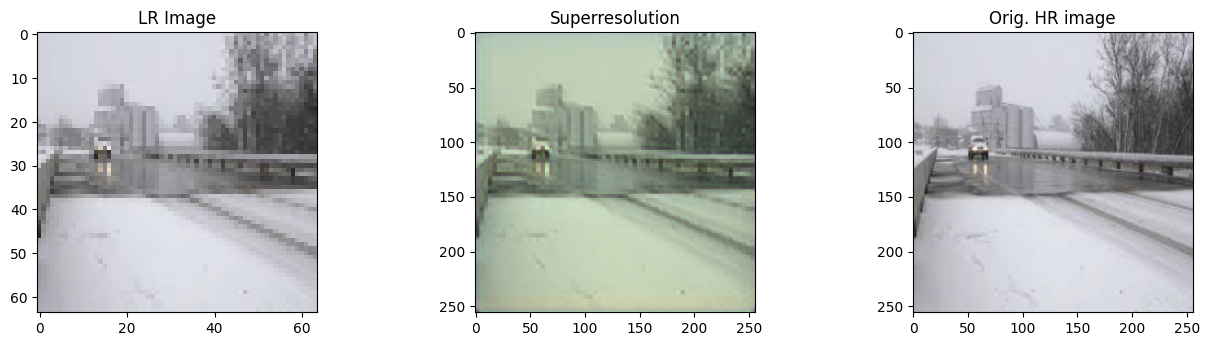

In [ ]:
# batch size 1, epoch 5
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 24ms/step


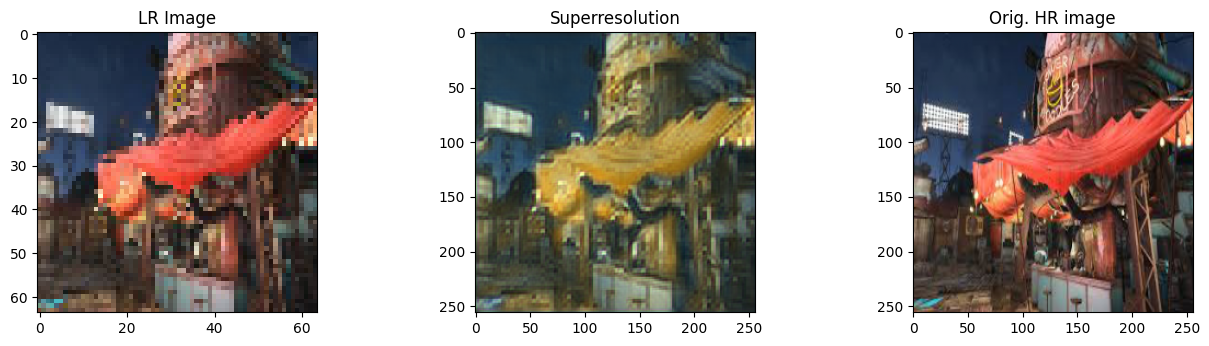

In [ ]:
# batch size 8, epoch 10
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 25ms/step


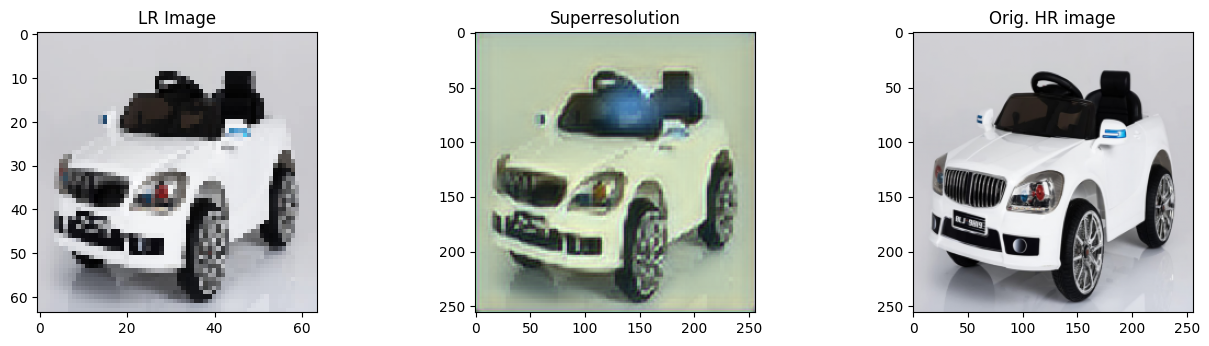

In [ ]:
# batch size 8, epoch 20
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 1s 1s/step


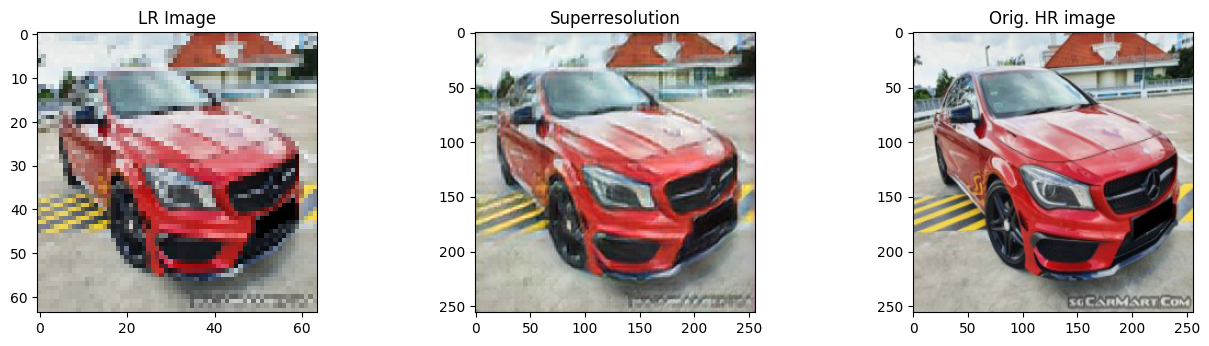

In [ ]:
# batch size 8, epoch 25
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 1s 1s/step


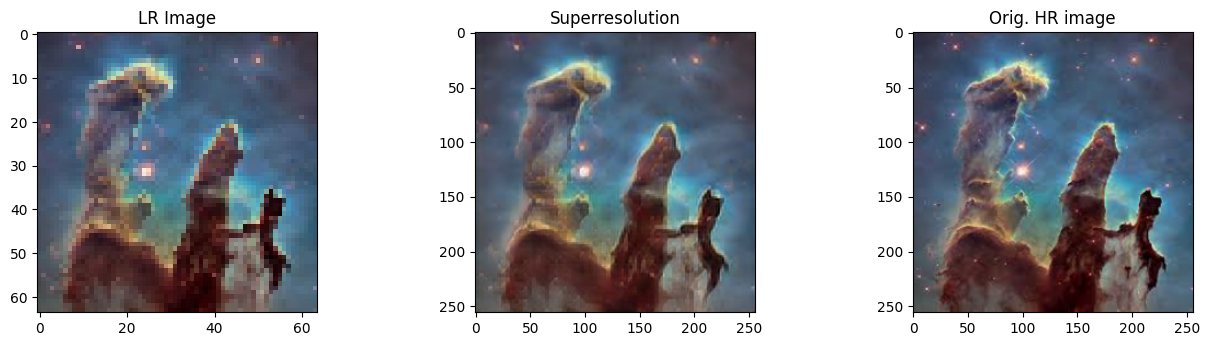

In [ ]:
# batch size 8, epoch 25
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 44ms/step


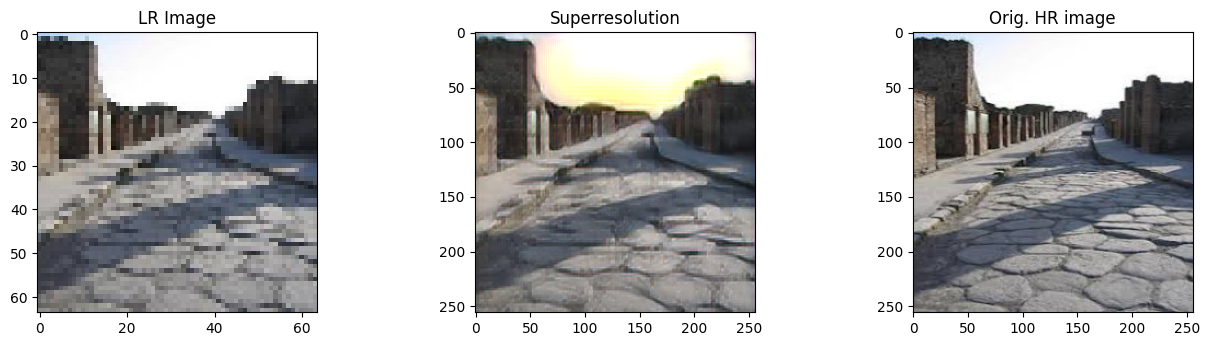

In [ ]:
# batch size 8, epoch 30
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 1s 1s/step


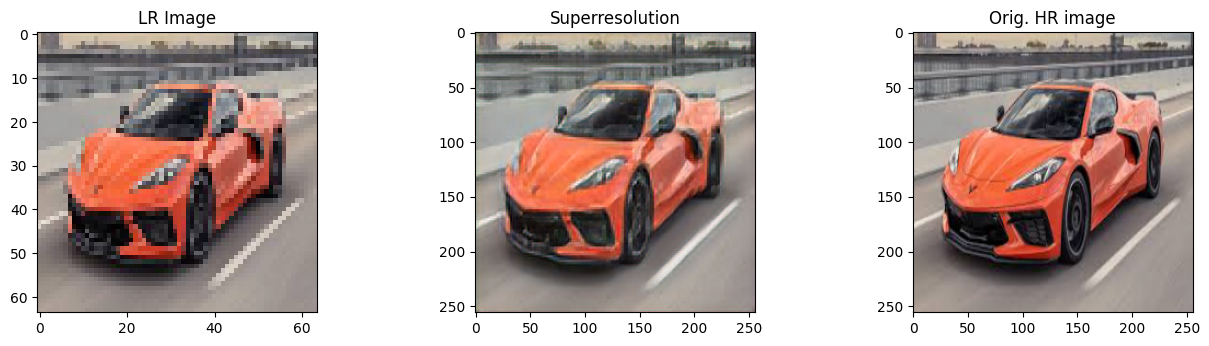

In [ ]:
# batch size 8, epoch 50
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

1/1 [==============================] - 0s 30ms/step


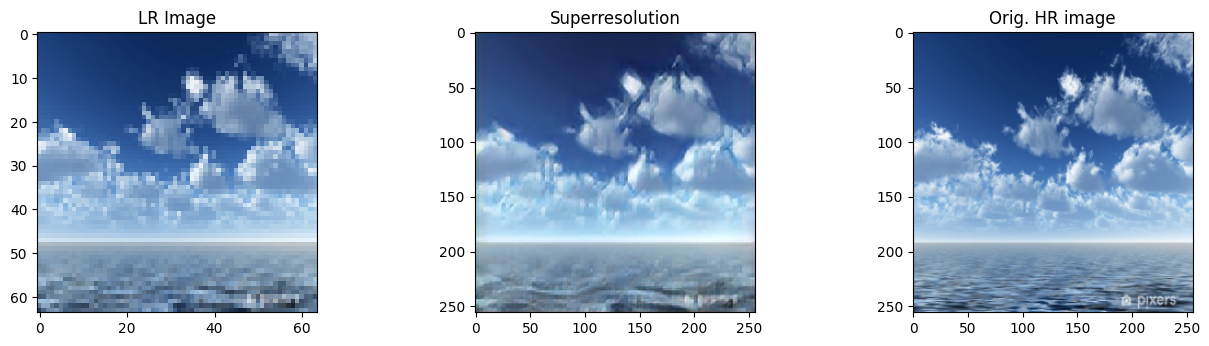

In [ ]:
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

# Video Super-resolution

In [ ]:
[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

In [ ]:
src_image.shape

(1, 64, 64, 3)

In [ ]:
lr_test.shape

(283, 64, 64, 3)

In [ ]:
def read_video_to_frames(dir_in):
    '''
    dir_in: input video directory, e.g. '/content/drive/MyDrive/mit computer vision project/sky_resized.mp4'
    return frames
    '''
    cap = cv2.VideoCapture(dir_in)
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # list of video frames
    frames = []

    while(cap.isOpened()):
        # read frame from the video
        ret, frame = cap.read()
        
        if ret is False:
            break
        #frame = cv2.resize(frame, (256,256))
        #frame = frame[:, 80:80+240]
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    # scale frame to 0-1
    #frames = np.array(frames) / 255.
    frames = np.array(frames)
    print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")
    return frames


In [ ]:
lr_dir = '/content/drive/MyDrive/mit computer vision project/output videos/dancer/dancer_resize.mp4'

In [ ]:
dir_resize = '/content/drive/MyDrive/mit computer vision project/output videos/dancer/dancer_resize.mp4'

In [ ]:
lr = read_video_to_frames(lr_dir)
hr = read_video_to_frames(dir_resize)

frames size: (155, 256, 256, 3) # (nb_frames, height, width, channel)
frames size: (155, 256, 256, 3) # (nb_frames, height, width, channel)


In [ ]:
lr_new = np.zeros((len(lr), 64, 64, 3))

for i in range(len(lr)):
  lr_new[i] = cv2.resize(lr[i], (64,64))/255.

In [ ]:
lr_new[0].shape

(64, 64, 3)

In [ ]:
lr_new.shape

(155, 64, 64, 3)

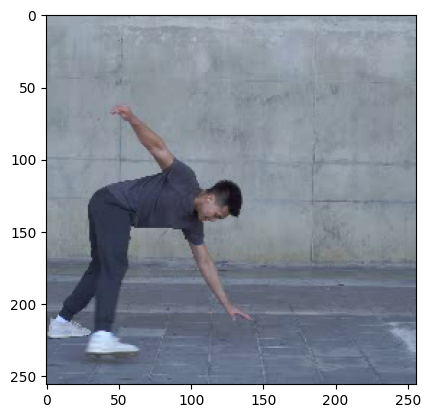

In [ ]:
plt.imshow(lr[0])

1/1 [==============================] - 3s 3s/step


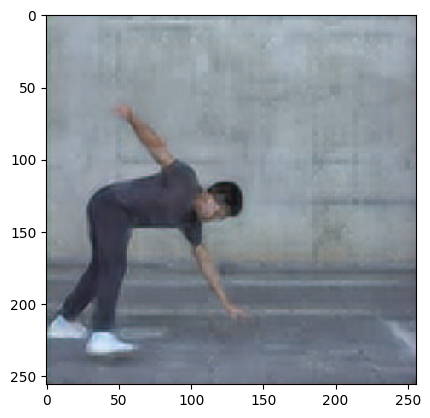

In [ ]:
plt.imshow(np.squeeze(generator.predict(np.expand_dims(lr_new[0],axis = 0))))